In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 8,
    "lines.linewidth": 2,
    "lines.markersize": 3,
})

# Load the hourly file
df = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")

# Convert to datetime and aggregate to daily totals
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

# Aggregate hourly data to daily totals (sum of MWh per day)
df_daily = df.groupby('date').agg({
    'Generation (MWh)': 'sum'
}).reset_index()
df_daily.columns = ['date', 'Generation (MWh)']
df_daily['datetime'] = pd.to_datetime(df_daily['date'])

print("Aggregated hourly data to daily totals")
print(df_daily.dtypes)
df_daily.head()

Aggregated hourly data to daily totals
date                        object
Generation (MWh)           float64
datetime            datetime64[ns]
dtype: object


,date,Generation (MWh),datetime
0,2022-01-01,51353.0,2022-01-01
1,2022-01-02,45689.0,2022-01-02
2,2022-01-03,51694.0,2022-01-03
3,2022-01-04,27742.0,2022-01-04
4,2022-01-05,35502.0,2022-01-05


In [2]:
# Use the daily aggregated data from previous cell
df = df_daily.copy()

# Convert datetime column to proper datetime format
df['ds'] = pd.to_datetime(df['datetime'])

# Rename the generation column for Prophet (daily total in MWh)
df['y'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['ds', 'y']].sort_values('ds')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total records (days): {len(df)}")
print(f"Average daily generation: {df['y'].mean():.2f} MWh")

ds    datetime64[ns]
y            float64
dtype: object
          ds        y
0 2022-01-01  51353.0
1 2022-01-02  45689.0
2 2022-01-03  51694.0
3 2022-01-04  27742.0
4 2022-01-05  35502.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Total records (days): 1096
Average daily generation: 108432.95 MWh


In [3]:
# 2.2 create new relevant variables or filters when useful
df['ds'] = pd.to_datetime(df['ds'], format='%Y/%m/%d %H:%M:%S')
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['weekday'] = df['ds'].dt.day_name()  # weekdays
df['is_weekend'] = df['ds'].dt.dayofweek >= 5  # True = weekends
df['season'] = df['ds'].dt.quarter  # season 1-4
# def seasons function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# apply season
df['season'] = df['month'].apply(get_season)

# Filter data for June to August only (months 6-8)
df = df[(df['month'] >= 6) & (df['month'] <= 8)].copy()

print(f"Filtered data for June to August (daily aggregated):")
print(f"  Period: {df['ds'].min()} to {df['ds'].max()}")
print(f"  Total days: {len(df)}")
print(f"  Years covered: {sorted(df['year'].unique())}")
print(f"  Average daily generation: {df['y'].mean():.2f} MWh")

df[df['season'] == 'Summer'].head()


Filtered data for June to August (daily aggregated):
  Period: 2022-06-01 00:00:00 to 2024-08-31 00:00:00
  Total days: 276
  Years covered: [2022, 2023, 2024]
  Average daily generation: 157770.92 MWh


,ds,y,year,month,day,weekday,is_weekend,season
151,2022-06-01,124812.0,2022,6,1,Wednesday,False,Summer
152,2022-06-02,107789.0,2022,6,2,Thursday,False,Summer
153,2022-06-03,120057.0,2022,6,3,Friday,False,Summer
154,2022-06-04,124978.0,2022,6,4,Saturday,True,Summer
155,2022-06-05,142973.0,2022,6,5,Sunday,True,Summer


In [4]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['y'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['y'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['y'] < lower_bound) | (df['y'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['y'].min():.2f} MWh")
print(f"  Max: {df['y'].max():.2f} MWh")
print(f"  Mean: {df['y'].mean():.2f} MWh")
print(f"  Median: {df['y'].median():.2f} MWh")
print(f"  Std: {df['y'].std():.2f} MWh")
print(f"  95th percentile: {df['y'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['y'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['y'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['y'] > max_reasonable, 'y'] = max_reasonable
df_cleaned.loc[df_cleaned['y'] < 0, 'y'] = 0  # Remove any negative values

capped_count = (df['y'] != df_cleaned['y']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 52057.00 MWh
  Max: 234514.00 MWh
  Mean: 157770.92 MWh
  Median: 157510.00 MWh
  Std: 35819.39 MWh
  95th percentile: 217674.75 MWh
  99th percentile: 228079.00 MWh

Capped 0 extreme values to max: 250886.90 MWh
Data is ready for modeling


In [5]:
# Split data into train (70%), validation (20%), and test (10%)
# Using only June to August data from 2022-2024
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# No hourly regressor needed for daily data
# For daily data, Prophet's built-in seasonality components are sufficient

print(f"Dataset: June to August (2022-2024) - Daily Aggregated")
print(f"Total days: {total_rows}")
print(f"\nTraining set: {len(train_df)} days ({len(train_df)/total_rows*100:.1f}%)")
print(f"  Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"  Avg daily generation: {train_df['y'].mean():.2f} MWh")
print(f"\nValidation set: {len(val_df)} days ({len(val_df)/total_rows*100:.1f}%)")
print(f"  Period: {val_df['ds'].min()} to {val_df['ds'].max()}")
print(f"  Avg daily generation: {val_df['y'].mean():.2f} MWh")
print(f"\nTest set: {len(test_df)} days ({len(test_df)/total_rows*100:.1f}%)")
print(f"  Period: {test_df['ds'].min()} to {test_df['ds'].max()}")
print(f"  Avg daily generation: {test_df['y'].mean():.2f} MWh")


Dataset: June to August (2022-2024) - Daily Aggregated
Total days: 276

Training set: 193 days (69.9%)
  Period: 2022-06-01 00:00:00 to 2024-06-09 00:00:00
  Avg daily generation: 142715.13 MWh

Validation set: 55 days (19.9%)
  Period: 2024-06-10 00:00:00 to 2024-08-03 00:00:00
  Avg daily generation: 194417.58 MWh

Test set: 28 days (10.1%)
  Period: 2024-08-04 00:00:00 to 2024-08-31 00:00:00
  Avg daily generation: 189563.86 MWh


In [6]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Create and fit the model with tuned hyperparameters for DAILY data
model = Prophet(
    # Seasonality settings - no daily seasonality for daily aggregated data
    daily_seasonality=False,        # Disabled for daily data
    weekly_seasonality=True,        # Keep weekly patterns
    yearly_seasonality=True,        # Keep yearly patterns
    
    # Regularization parameters (prevent overfitting)
    changepoint_prior_scale=0.05,   # Slightly higher for daily data
    seasonality_prior_scale=10.0,   # Higher for capturing daily variations
    
    # Changepoint settings
    changepoint_range=0.8,          # Use 80% of data for detecting trend changes
    n_changepoints=10,              # Fewer changepoints for daily data
    
    # Seasonality mode
    seasonality_mode='additive',    # Additive mode for stability
    
    # Interval width
    interval_width=0.95,            # 95% confidence intervals
    
    # Growth model
    growth='linear',                # Linear growth
    
    # Other settings
    mcmc_samples=0,                 # Use MAP estimation (faster)
    uncertainty_samples=1000        # Samples for uncertainty intervals
)

# Add floor constraint (solar generation cannot be negative)
train_df['floor'] = 0
model.fit(train_df)

print("Training Prophet model for DAILY aggregated data...")
print("="*60)
print("Model Configuration:")
print(f"  - Data granularity: DAILY (sum of hourly MWh per day)")
print(f"  - Growth: {model.growth}")
print(f"  - Changepoint prior scale: {model.changepoint_prior_scale}")
print(f"  - Seasonality prior scale: {model.seasonality_prior_scale}")
print(f"  - Seasonality mode: {model.seasonality_mode}")
print(f"  - Floor constraint: 0 (no negative values)")
print(f"  - Weekly seasonality: Enabled")
print(f"  - Yearly seasonality: Enabled")
print("="*60)

print("\nTraining complete!")

c:\Users\Archer\Documents\Vscode\venv\p312_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22:03:38 - cmdstanpy - INFO - Chain [1] start processing
22:03:38 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model for DAILY aggregated data...
Model Configuration:
  - Data granularity: DAILY (sum of hourly MWh per day)
  - Growth: linear
  - Changepoint prior scale: 0.05
  - Seasonality prior scale: 10.0
  - Seasonality mode: additive
  - Floor constraint: 0 (no negative values)
  - Weekly seasonality: Enabled
  - Yearly seasonality: Enabled

Training complete!


## Daily Aggregated Generation Forecasting

This model uses **daily aggregated generation data** (sum of hourly MWh per day) for forecasting:

### 1. **Data Aggregation**
- Hourly generation data is summed to create daily total generation (MWh/day)
- Reduces data granularity from ~8760 hourly points to ~365 daily points per year
- Smooths out hourly variations and focuses on day-to-day patterns

### 2. **Model Configuration**
- **No daily seasonality**: Not applicable for daily aggregated data
- **Weekly seasonality**: Captures day-of-week patterns (weekday vs weekend)
- **Yearly seasonality**: Captures seasonal variations across the year
- **Floor constraint**: Ensures predictions stay non-negative

### 3. **Benefits**
- ✅ Simpler model with fewer parameters
- ✅ More stable predictions less affected by hourly noise
- ✅ Better for understanding overall daily production trends
- ✅ Useful for daily energy planning and scheduling
- ✅ Reduced computational complexity

### 4. **Use Cases**
- Daily energy production forecasting
- Energy market bidding (daily ahead markets)
- Monthly/seasonal planning

- Performance monitoring and benchmarking

In [7]:
# Optional: Hyperparameter tuning with cross-validation
# This cell can take several minutes to run - uncomment to enable

"""
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

print("Starting hyperparameter tuning...")
print("This may take 5-10 minutes...")

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 15.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store results
results = []

for params in all_params[:8]:  # Test first 8 combinations (limit for speed)
    # Create model with current params
    m = Prophet(**params, 
                daily_seasonality=True, 
                weekly_seasonality=True, 
                yearly_seasonality=True)
    m.fit(train_df)
    
    # Validate on validation set
    val_pred = m.predict(val_df[['ds']])
    val_mae = mean_absolute_error(val_df['y'].values, val_pred['yhat'].values)
    
    # Store result
    results.append({**params, 'mae': val_mae})
    print(f"Tested: {params} -> MAE: {val_mae:.2f}")

# Find best parameters
best_params = min(results, key=lambda x: x['mae'])
print(f"\nBest parameters found:")
print(best_params)
"""

print("Hyperparameter tuning cell (commented out for speed)")
print("Uncomment to run full grid search")

Hyperparameter tuning cell (commented out for speed)
Uncomment to run full grid search


In [8]:
# Validate model on validation set
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on validation data (add floor constraint)
val_df_pred = val_df.copy()
val_df_pred['floor'] = 0
val_forecast = model.predict(val_df_pred[['ds', 'floor']])

# Clip predictions to non-negative values (safety check)
val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)
val_forecast['yhat_lower'] = val_forecast['yhat_lower'].clip(lower=0)
val_forecast['yhat_upper'] = val_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
val_actual = val_df['y'].values
val_pred = val_forecast['yhat'].values

# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

# Calculate MAPE excluding very small values (< 100 MWh/day threshold for daily data)
threshold = 100  # MWh/day
significant_mask = val_actual >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((val_actual[significant_mask] - val_pred[significant_mask]) / val_actual[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance (Daily):")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh/day")
print(f"RMSE: {val_rmse:.2f} MWh/day")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh/day): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (val_actual == 0).sum()
low_gen_count = ((val_actual > 0) & (val_actual < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(val_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh/day): {low_gen_count} ({low_gen_count/len(val_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh/day): {significant_mask.sum()} ({significant_mask.sum()/len(val_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh/day")
print(f"  Max: {val_pred.max():.2f} MWh/day")
print(f"  Mean: {val_pred.mean():.2f} MWh/day")

Validation Set Performance (Daily):
MAE:  23768.82 MWh/day
RMSE: 29364.72 MWh/day
MAPE (generation >= 100 MWh/day): 13.74%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-100 MWh/day): 0 (0.0%)
  Significant generation (>=100 MWh/day): 55 (100.0%)

Prediction range:
  Min: 168578.06 MWh/day
  Max: 203063.45 MWh/day
  Mean: 193097.25 MWh/day


In [9]:
# Test model on test set
test_df_pred = test_df.copy()
test_df_pred['floor'] = 0
test_forecast = model.predict(test_df_pred[['ds', 'floor']])

# Clip predictions to non-negative values (safety check)
test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)
test_forecast['yhat_lower'] = test_forecast['yhat_lower'].clip(lower=0)
test_forecast['yhat_upper'] = test_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
test_actual = test_df['y'].values
test_pred = test_forecast['yhat'].values

# Calculate test metrics
test_mae = mean_absolute_error(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Calculate MAPE excluding very small values (< 100 MWh threshold for daily data)
threshold = 100  # MWh/day
significant_mask = test_actual >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((test_actual[significant_mask] - test_pred[significant_mask]) / test_actual[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance (Daily):")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh/day")
print(f"RMSE: {test_rmse:.2f} MWh/day")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh/day): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (test_actual == 0).sum()
low_gen_count = ((test_actual > 0) & (test_actual < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(test_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh/day): {low_gen_count} ({low_gen_count/len(test_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh/day): {significant_mask.sum()} ({significant_mask.sum()/len(test_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range (daily):") 
print(f"  Min: {test_pred.min():.2f} MWh/day")
print(f"  Max: {test_pred.max():.2f} MWh/day")
print(f"  Mean: {test_pred.mean():.2f} MWh/day")

Test Set Performance (Daily):
MAE:  12486.40 MWh/day
RMSE: 16064.64 MWh/day
MAPE (generation >= 100 MWh/day): 7.14%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-100 MWh/day): 0 (0.0%)
  Significant generation (>=100 MWh/day): 28 (100.0%)

Prediction range (daily):
  Min: 166767.51 MWh/day
  Max: 199523.99 MWh/day
  Mean: 189011.44 MWh/day


In [10]:
# Diagnostic: Analyze error distribution on validation set
val_df_analysis = val_df.copy()
val_df_analysis['predicted'] = val_pred
val_df_analysis['error'] = val_actual - val_pred
val_df_analysis['abs_error'] = np.abs(val_df_analysis['error'])
val_df_analysis['pct_error'] = np.where(
    val_actual >= 10, 
    np.abs(val_df_analysis['error'] / val_actual) * 100,
    np.nan
)

print("Error Analysis on Validation Set:")
print("=" * 50)
print(f"\nActual generation statistics:")
print(val_df_analysis['y'].describe())

print(f"\nPredicted generation statistics:")
print(val_df_analysis['predicted'].describe())

print(f"\nAbsolute error statistics:")
print(val_df_analysis['abs_error'].describe())

print(f"\nPercentage error statistics (excluding low generation):")
print(val_df_analysis['pct_error'].describe())

# Show some examples of high errors
print(f"\n5 Largest absolute errors:")
print(val_df_analysis.nlargest(5, 'abs_error')[['ds', 'y', 'predicted', 'error', 'pct_error']])

Error Analysis on Validation Set:

Actual generation statistics:
count        55.000000
mean     194417.581818
std       31053.851107
min      108345.000000
25%      170257.500000
50%      208290.000000
75%      217814.500000
max      234514.000000
Name: y, dtype: float64

Predicted generation statistics:
count        55.000000
mean     193097.248556
std        8962.516864
min      168578.062065
25%      191046.371054
50%      196342.667024
75%      199003.653306
max      203063.454767
Name: predicted, dtype: float64

Absolute error statistics:
count       55.000000
mean     23768.818520
std      17402.190301
min       1066.937935
25%      13990.886982
50%      19609.138958
75%      30832.293542
max      89422.184147
Name: abs_error, dtype: float64

Percentage error statistics (excluding low generation):
count    55.000000
mean     13.740379
std      14.719279
min       0.628924
25%       7.348637
50%       9.099296
75%      14.733612
max      82.534666
Name: pct_error, dtype: float64


In [11]:
# Create forecast for June to August 2025 (DAILY)
# Generate future dates from 2025-06-01 to 2025-08-31 (daily frequency)
future_2025 = pd.DataFrame({
    'ds': pd.date_range(start='2025-06-01', end='2025-08-31', freq='D'),
    'floor': 0  # Add floor constraint
})

print(f"Forecasting for June to August 2025 (DAILY)...")
print(f"Period: {future_2025['ds'].min()} to {future_2025['ds'].max()}")
print(f"Total forecast days: {len(future_2025)}")

forecast_2025 = model.predict(future_2025[['ds', 'floor']])

# Clip to ensure no negative predictions
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)
forecast_2025['yhat_lower'] = forecast_2025['yhat_lower'].clip(lower=0)
forecast_2025['yhat_upper'] = forecast_2025['yhat_upper'].clip(lower=0)

print("\nForecast complete!")
print(f"Daily forecast range:")
print(f"  Min: {forecast_2025['yhat'].min():.2f} MWh/day")
print(f"  Max: {forecast_2025['yhat'].max():.2f} MWh/day")
print(f"  Mean: {forecast_2025['yhat'].mean():.2f} MWh/day")
print(f"  Total forecast for Jun-Aug 2025: {forecast_2025['yhat'].sum():.2f} MWh")

# Show average by month
forecast_2025['month'] = forecast_2025['ds'].dt.month
monthly_avg = forecast_2025.groupby('month')['yhat'].agg(['mean', 'sum'])
print(f"\nAverage generation by month:")
for month_num, row in monthly_avg.iterrows():
    month_name = pd.to_datetime(f'2025-{month_num:02d}-01').strftime('%B')
    print(f"  {month_name}: {row['mean']:.2f} MWh/day (Total: {row['sum']:.2f} MWh)")

Forecasting for June to August 2025 (DAILY)...
Period: 2025-06-01 00:00:00 to 2025-08-31 00:00:00
Total forecast days: 92

Forecast complete!
Daily forecast range:
  Min: 198934.11 MWh/day
  Max: 235488.66 MWh/day
  Mean: 222174.35 MWh/day
  Total forecast for Jun-Aug 2025: 20440040.46 MWh

Average generation by month:
  June: 213809.49 MWh/day (Total: 6414284.84 MWh)
  July: 229804.04 MWh/day (Total: 7123925.19 MWh)
  August: 222639.69 MWh/day (Total: 6901830.43 MWh)


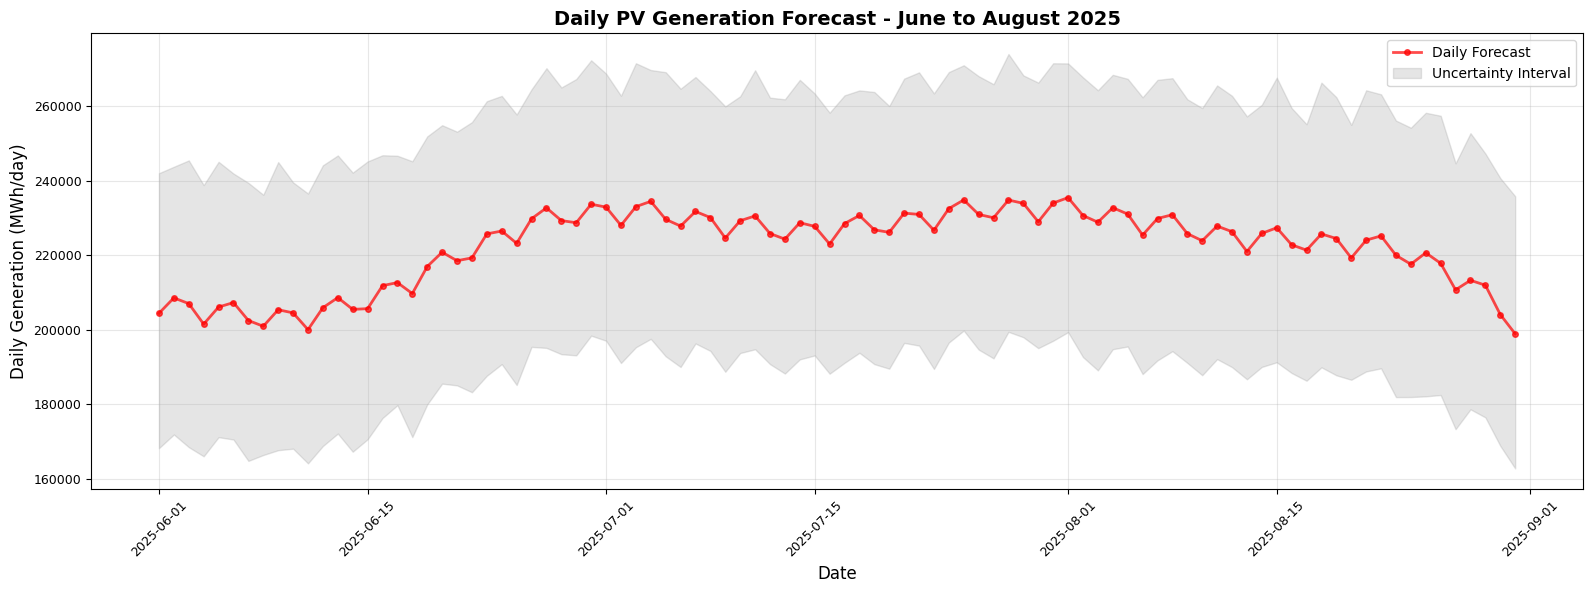


Daily Generation Statistics by Month:
June:
  Days: 30
  Avg daily: 213809.49 MWh/day
  Min daily: 200063.53 MWh/day
  Max daily: 233722.84 MWh/day
  Total: 6414284.84 MWh

July:
  Days: 31
  Avg daily: 229804.04 MWh/day
  Min daily: 223036.54 MWh/day
  Max daily: 234869.30 MWh/day
  Total: 7123925.19 MWh

August:
  Days: 31
  Avg daily: 222639.69 MWh/day
  Min daily: 198934.11 MWh/day
  Max daily: 235488.66 MWh/day
  Total: 6901830.43 MWh



In [12]:
# Visualize daily generation pattern - show time series
import matplotlib.pyplot as plt

# Create figure with daily forecast
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Plot daily forecast values
ax.plot(forecast_2025['ds'], forecast_2025['yhat'], 'ro-', 
        linewidth=2, markersize=4, label='Daily Forecast', alpha=0.7)

# Add uncertainty intervals
ax.fill_between(forecast_2025['ds'], 
                forecast_2025['yhat_lower'], 
                forecast_2025['yhat_upper'],
                alpha=0.2, color='gray', label='Uncertainty Interval')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Generation (MWh/day)', fontsize=12)
ax.set_title('Daily PV Generation Forecast - June to August 2025', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='upper right')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print statistics by month
print("\nDaily Generation Statistics by Month:")
print("="*60)
for month_num in [6, 7, 8]:
    month_data = forecast_2025[forecast_2025['month'] == month_num]
    month_name = pd.to_datetime(f'2025-{month_num:02d}-01').strftime('%B')
    print(f"{month_name}:")
    print(f"  Days: {len(month_data)}")
    print(f"  Avg daily: {month_data['yhat'].mean():.2f} MWh/day")
    print(f"  Min daily: {month_data['yhat'].min():.2f} MWh/day")
    print(f"  Max daily: {month_data['yhat'].max():.2f} MWh/day")
    print(f"  Total: {month_data['yhat'].sum():.2f} MWh")
    print()

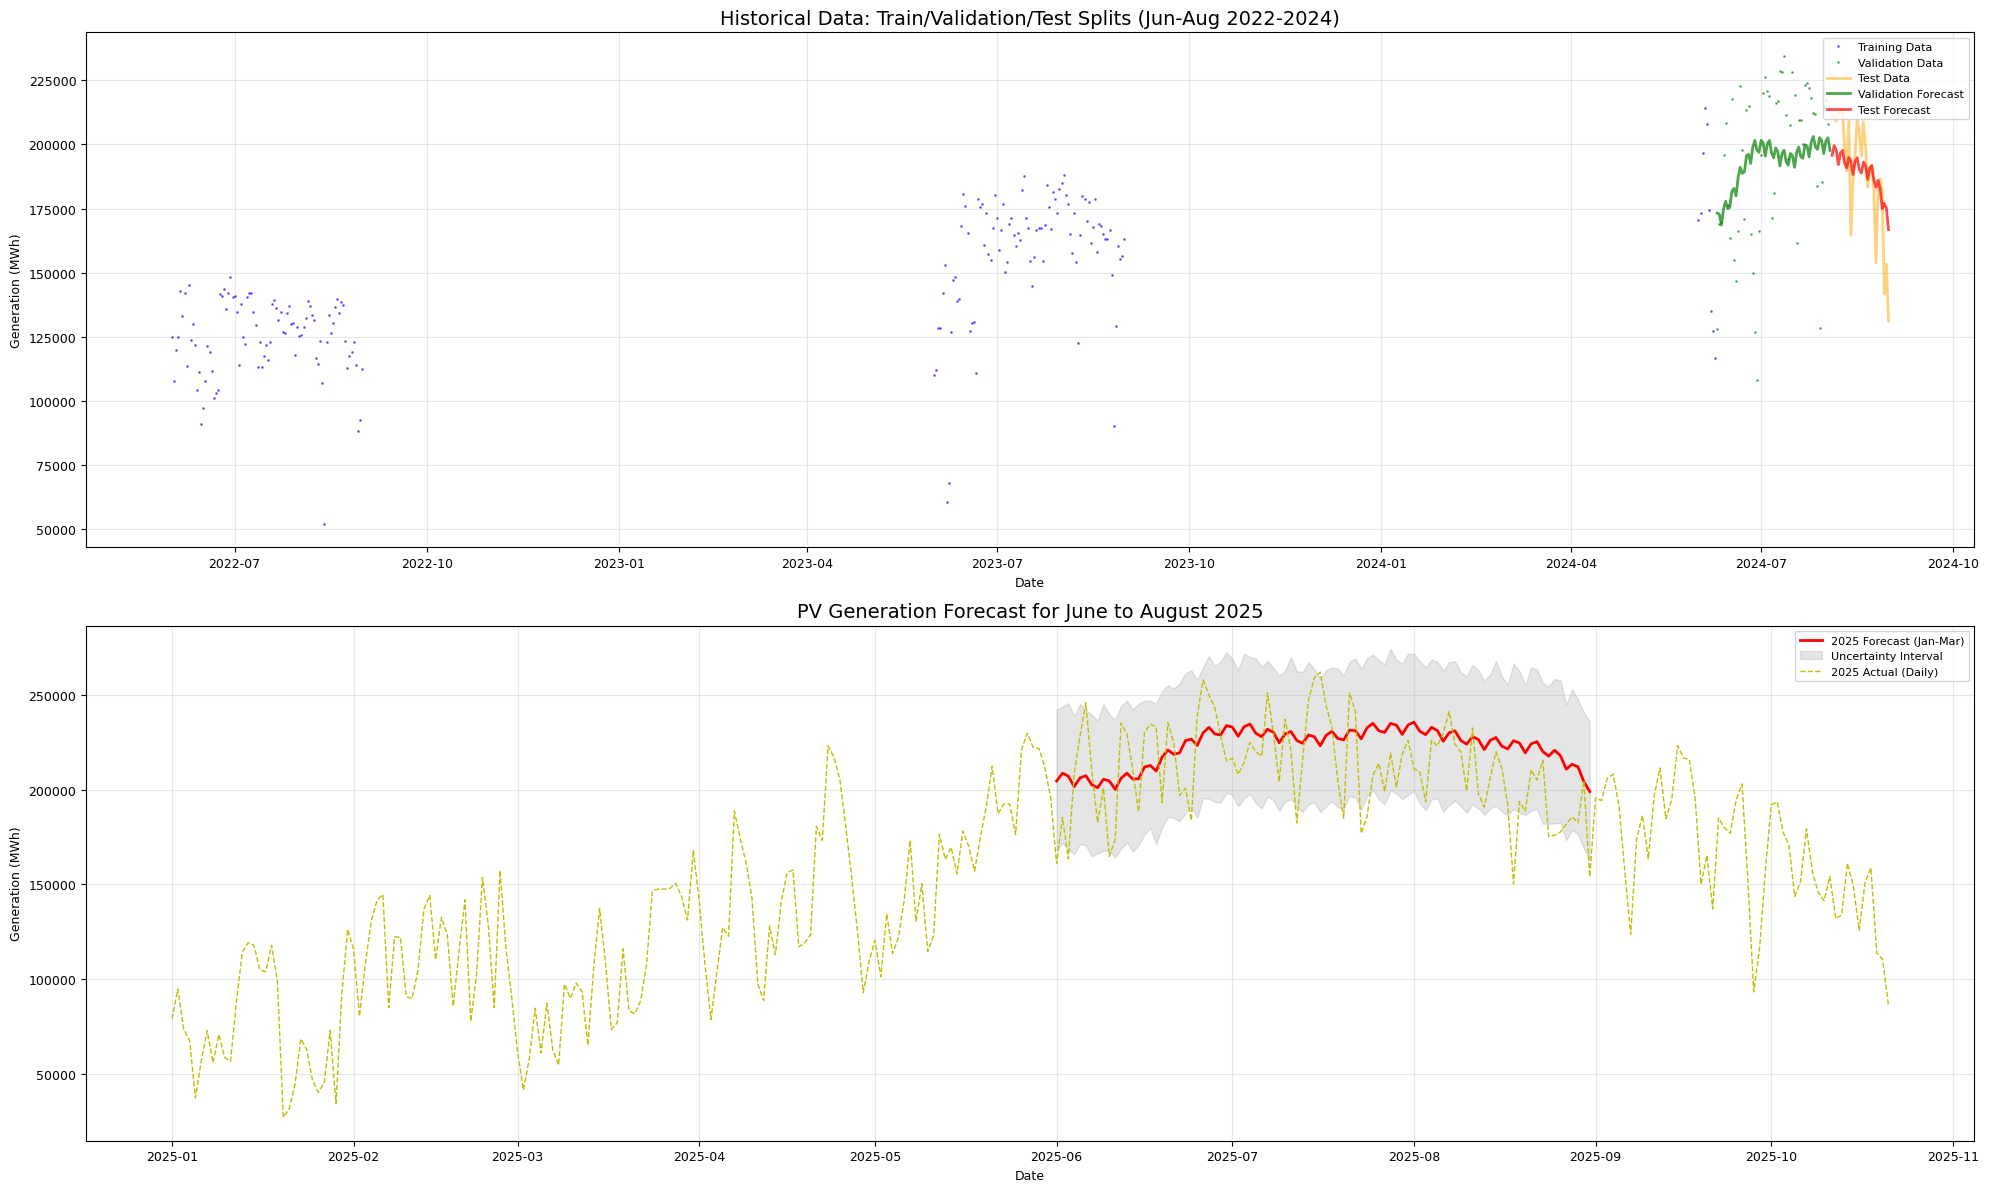

In [13]:
# Visualize train/val/test splits and model performance
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits (Jun-Aug 2022-2024)
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['ds'], val_df['y'], 'g.', label='Validation Data', alpha=0.5, markersize=2)
ax1.plot(test_df['ds'], test_df['y'], 'orange', label='Test Data', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_forecast['ds'], val_forecast['yhat'], 'g-', label='Validation Forecast', linewidth=2, alpha=0.7)
ax1.plot(test_forecast['ds'], test_forecast['yhat'], 'r-', label='Test Forecast', linewidth=2, alpha=0.7)

ax1.set_title('Historical Data: Train/Validation/Test Splits (Jun-Aug 2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast (Jan-Mar)
ax2 = axes[1]
ax2.plot(forecast_2025['ds'], forecast_2025['yhat'], 'r-', label='2025 Forecast (Jan-Mar)', linewidth=2)
ax2.fill_between(forecast_2025['ds'], 
                 forecast_2025['yhat_lower'], 
                 forecast_2025['yhat_upper'], 
                 color='gray', 
                 alpha=0.2, 
                 label='Uncertainty Interval')

# Load and aggregate actual data to daily (without modifying original)
df_2025_actual = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025_actual['datetime'] = pd.to_datetime(df_2025_actual['datetime'])

# Create separate aggregated dataframe for daily actual
df_2025_actual_daily = df_2025_actual.copy()
df_2025_actual_daily['date'] = df_2025_actual_daily['datetime'].dt.date
df_2025_actual_daily = df_2025_actual_daily.groupby('date').agg({
    'Generation (MWh)': 'sum'
}).reset_index()
df_2025_actual_daily['datetime'] = pd.to_datetime(df_2025_actual_daily['date'])

# Plot daily actual data
ax2.plot(df_2025_actual_daily['datetime'], df_2025_actual_daily['Generation (MWh)'], 
         'y--', label='2025 Actual (Daily)', linewidth=1)

ax2.set_title('PV Generation Forecast for June to August 2025', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


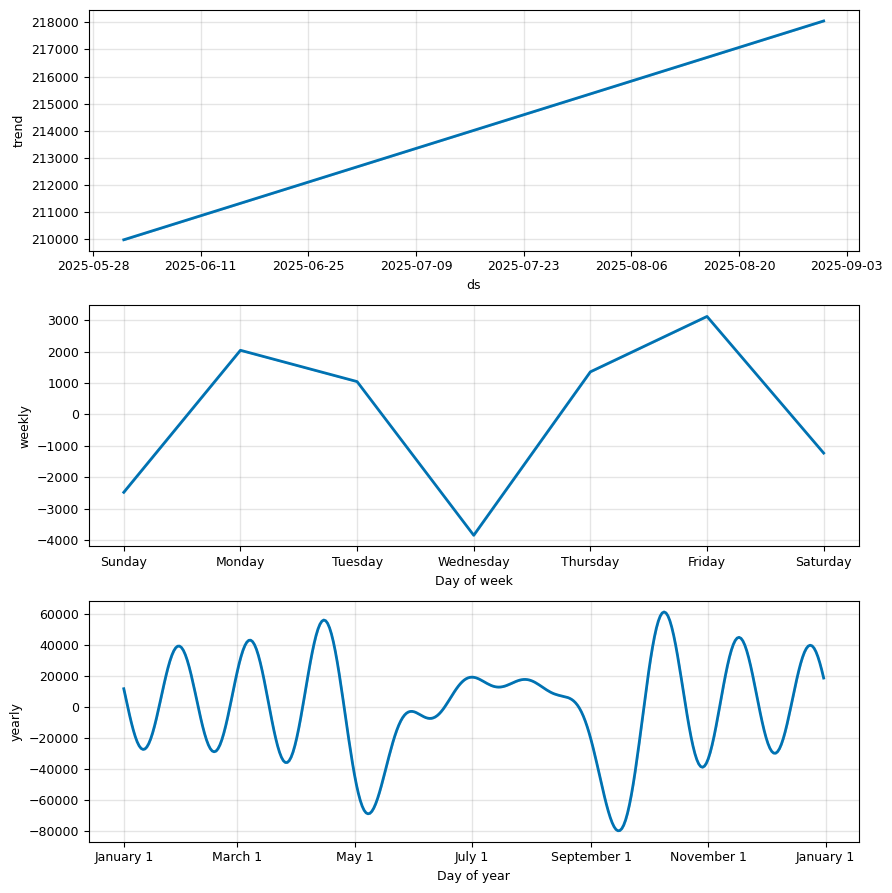

In [14]:
# Show seasonal components
fig = model.plot_components(forecast_2025)
plt.tight_layout()
plt.show()

In [15]:
# Export 2025 forecast (Jun-Aug) to CSV - DAILY data
forecast_export = forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export['date'] = forecast_export['ds'].dt.strftime('%Y-%m-%d')
forecast_export = forecast_export[['date', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'date': 'Date',
    'yhat': 'Forecast_Generation_MWh_per_day',
    'yhat_lower': 'Forecast_Lower_Bound_MWh_per_day',
    'yhat_upper': 'Forecast_Upper_Bound_MWh_per_day'
})

output_file = 'pv_forecast_2025_jun_aug_daily.csv'
#forecast_export.to_csv(output_file, index=False)
print(f"2025 daily forecast (June to August) exported to: {output_file}")
print(f"\nSummary statistics of 2025 Jun-Aug daily forecast:")
print(forecast_export.describe())

2025 daily forecast (June to August) exported to: pv_forecast_2025_jun_aug_daily.csv

Summary statistics of 2025 Jun-Aug daily forecast:
       Forecast_Generation_MWh_per_day  Forecast_Lower_Bound_MWh_per_day  \
count                        92.000000                         92.000000   
mean                     222174.352867                     186017.982864   
std                       10216.290599                      10278.177621   
min                      198934.113393                     162806.510056   
25%                      216072.888317                     179935.757559   
50%                      225795.134309                     189541.495063   
75%                      229937.300263                     193795.817392   
max                      235488.659166                     199812.505598   

       Forecast_Upper_Bound_MWh_per_day  
count                         92.000000  
mean                      258734.988994  
std                        10283.739902  
min       

In [16]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025

,datetime,Area,Production Type,Generation (MWh)
0,2025-01-01 00:00:00,BZN|ES,Solar,4.000000
1,2025-01-01 01:00:00,BZN|ES,Solar,4.000000
2,2025-01-01 02:00:00,BZN|ES,Solar,4.000000
3,2025-01-01 03:00:00,BZN|ES,Solar,4.000000
4,2025-01-01 04:00:00,BZN|ES,Solar,4.000000
...,...,...,...,...
7047,2025-10-21 16:00:00,BZN|ES,Solar,11324.000000
7048,2025-10-21 17:00:00,BZN|ES,Solar,8866.000000
7049,2025-10-21 18:00:00,BZN|ES,Solar,4370.000000
7050,2025-10-21 19:00:00,BZN|ES,Solar,688.000000


## Disaggregation to Hourly Resolution

Now we'll disaggregate the daily forecasts to hourly resolution using weighting factors based on historical irradiation patterns.

Historical hourly generation patterns (June-August 2022-2024):
Data points used: 6624

Hourly weights summary:
       count         mean          std         min         25%          50%  \
month                                                                         
6       24.0  6093.193056  5777.383130  240.811111  444.944444  4409.600000   
7       24.0  7001.788530  6597.036853  397.268817  574.932796  4834.284946   
8       24.0  6610.880824  6718.618238  202.731183  517.005376  2831.505376   

                75%           max  
month                              
6      12273.186111  13865.088889  
7      14343.483871  15570.516129  
8      14306.198925  15884.688172  


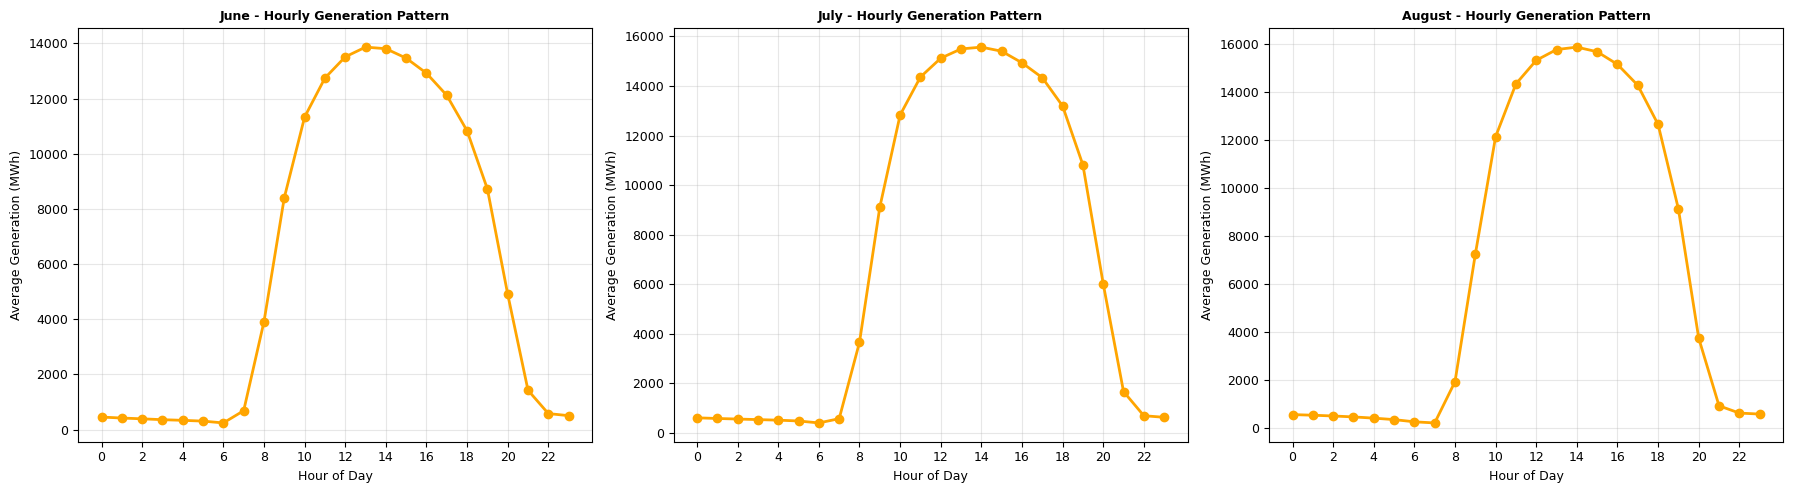


Peak generation hours:
  June: Hour 13 with 13865.09 MWh average
  July: Hour 14 with 15570.52 MWh average
  August: Hour 14 with 15884.69 MWh average


In [17]:
# Step 1: Create hourly weighting factors from historical data (2022-2024)
# Load the hourly historical data to analyze generation patterns
df_hourly_hist = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")
df_hourly_hist['datetime'] = pd.to_datetime(df_hourly_hist['datetime'])
df_hourly_hist['hour'] = df_hourly_hist['datetime'].dt.hour
df_hourly_hist['month'] = df_hourly_hist['datetime'].dt.month
df_hourly_hist['date'] = df_hourly_hist['datetime'].dt.date

# Filter for June to August (our forecast period)
df_hourly_hist_summer = df_hourly_hist[df_hourly_hist['month'].isin([6, 7, 8])].copy()

# Calculate the average hourly generation pattern for each month
# This will serve as our weighting profile
hourly_weights = df_hourly_hist_summer.groupby(['month', 'hour']).agg({
    'Generation (MWh)': 'mean'
}).reset_index()
hourly_weights.columns = ['month', 'hour', 'avg_generation']

print("Historical hourly generation patterns (June-August 2022-2024):")
print(f"Data points used: {len(df_hourly_hist_summer)}")
print(f"\nHourly weights summary:")
print(hourly_weights.groupby('month')['avg_generation'].describe())

# Visualize the hourly weight profiles by month
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
months_names = {6: 'June', 7: 'July', 8: 'August'}

for idx, month in enumerate([6, 7, 8]):
    month_data = hourly_weights[hourly_weights['month'] == month]
    axes[idx].plot(month_data['hour'], month_data['avg_generation'], 
                   marker='o', linewidth=2, markersize=6, color='orange')
    axes[idx].set_title(f'{months_names[month]} - Hourly Generation Pattern', fontweight='bold')
    axes[idx].set_xlabel('Hour of Day')
    axes[idx].set_ylabel('Average Generation (MWh)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

print("\nPeak generation hours:")
for month in [6, 7, 8]:
    month_data = hourly_weights[hourly_weights['month'] == month]
    peak_hour = month_data.loc[month_data['avg_generation'].idxmax(), 'hour']
    peak_gen = month_data['avg_generation'].max()
    print(f"  {months_names[month]}: Hour {int(peak_hour)} with {peak_gen:.2f} MWh average")

Normalized hourly weights (sum to 1.0 per day for each month):
month
6    1.0
7    1.0
8    1.0
Name: weight, dtype: float64

Weight distribution by month:
       count      mean       std       min       25%       50%       75%  \
month                                                                      
6       24.0  0.041667  0.039507  0.001647  0.003043  0.030154  0.083927   
7       24.0  0.041667  0.039258  0.002364  0.003421  0.028768  0.085356   
8       24.0  0.041667  0.042346  0.001278  0.003259  0.017846  0.090168   

            max  
month            
6      0.094813  
7      0.092658  
8      0.100117  


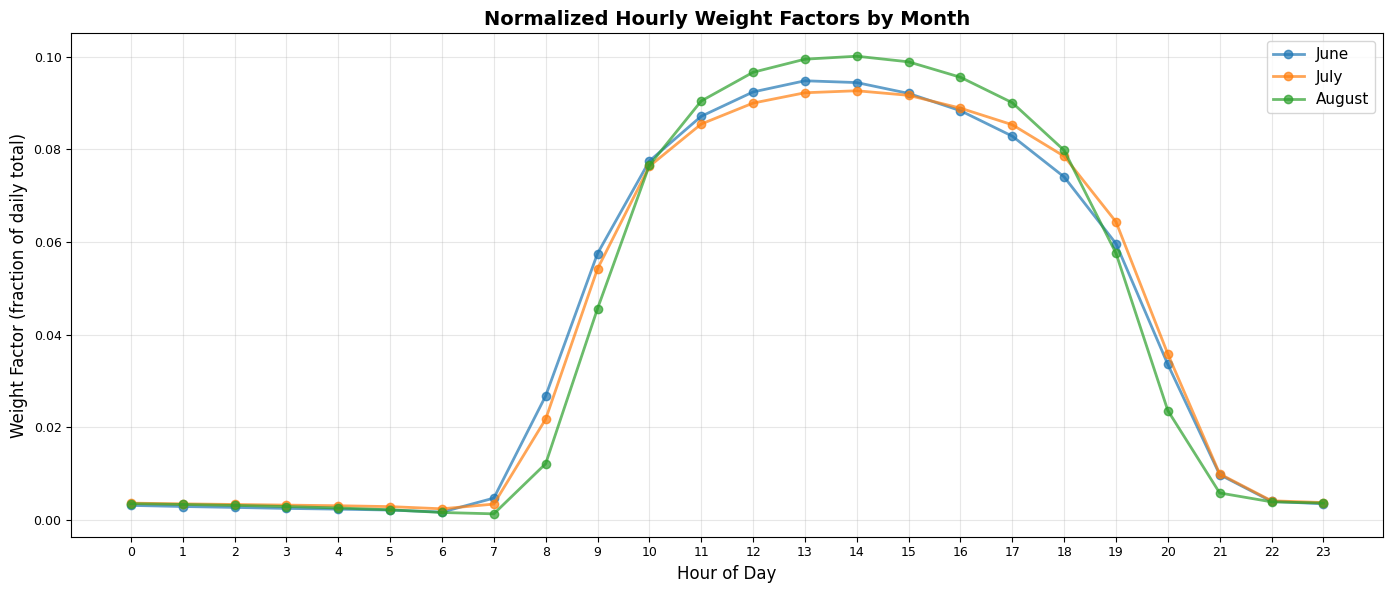


Complete weight factors table:
          June      July    August
hour                              
0     0.003103  0.003593  0.003473
1     0.002861  0.003433  0.003309
2     0.002666  0.003300  0.003107
3     0.002451  0.003166  0.002861
4     0.002293  0.003028  0.002543
5     0.002099  0.002837  0.002155
6     0.001647  0.002364  0.001570
7     0.004679  0.003387  0.001278
8     0.026758  0.021738  0.012109
9     0.057504  0.054200  0.045602
10    0.077475  0.076343  0.076559
11    0.087144  0.085469  0.090442
12    0.092399  0.089995  0.096648
13    0.094813  0.092223  0.099475
14    0.094424  0.092658  0.100117
15    0.092084  0.091672  0.098902
16    0.088349  0.088896  0.095574
17    0.082855  0.085318  0.090077
18    0.074050  0.078516  0.079784
19    0.059639  0.064350  0.057562
20    0.033550  0.035798  0.023583
21    0.009743  0.009902  0.005788
22    0.003967  0.004098  0.003870
23    0.003448  0.003717  0.003611


In [18]:
# Step 2: Normalize weights so they sum to 1 for each day
# This ensures daily total is preserved when disaggregating

# For each month, normalize the hourly weights to sum to 1
hourly_weights_normalized = hourly_weights.copy()

for month in [6, 7, 8]:
    month_mask = hourly_weights_normalized['month'] == month
    month_sum = hourly_weights_normalized.loc[month_mask, 'avg_generation'].sum()
    hourly_weights_normalized.loc[month_mask, 'weight'] = (
        hourly_weights_normalized.loc[month_mask, 'avg_generation'] / month_sum
    )

print("Normalized hourly weights (sum to 1.0 per day for each month):")
print(hourly_weights_normalized.groupby('month')['weight'].sum())
print("\nWeight distribution by month:")
print(hourly_weights_normalized.groupby('month')['weight'].describe())

# Visualize normalized weights
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
months_names = {6: 'June', 7: 'July', 8: 'August'}
colors = {'6': 'lightblue', '7': 'coral', '8': 'lightgreen'}

for month in [6, 7, 8]:
    month_data = hourly_weights_normalized[hourly_weights_normalized['month'] == month]
    ax.plot(month_data['hour'], month_data['weight'], 
            marker='o', linewidth=2, markersize=6, 
            label=months_names[month], alpha=0.7)

ax.set_title('Normalized Hourly Weight Factors by Month', fontweight='bold', fontsize=14)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Weight Factor (fraction of daily total)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24, 1))
plt.tight_layout()
plt.show()

# Show the weights table
print("\nComplete weight factors table:")
pivot_weights = hourly_weights_normalized.pivot(index='hour', columns='month', values='weight')
pivot_weights.columns = [months_names[col] for col in pivot_weights.columns]
print(pivot_weights.to_string())

In [19]:
# Step 3: Disaggregate daily forecasts to hourly using the weight factors
# Create hourly forecast from daily forecast

# Prepare forecast data for disaggregation
forecast_2025_disagg = forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_2025_disagg['month'] = forecast_2025_disagg['ds'].dt.month

# Create hourly timestamps for each day
hourly_forecast_list = []

for idx, row in forecast_2025_disagg.iterrows():
    date = row['ds']
    month = row['month']
    daily_forecast = row['yhat']
    daily_lower = row['yhat_lower']
    daily_upper = row['yhat_upper']
    
    # Get weights for this month
    month_weights = hourly_weights_normalized[
        hourly_weights_normalized['month'] == month
    ].set_index('hour')['weight']
    
    # Create 24 hourly records for this day
    for hour in range(24):
        hourly_datetime = pd.Timestamp(date.year, date.month, date.day, hour)
        weight = month_weights.loc[hour]
        
        hourly_forecast_list.append({
            'datetime': hourly_datetime,
            'date': date.date(),
            'hour': hour,
            'month': month,
            'weight': weight,
            'hourly_forecast': daily_forecast * weight,
            'hourly_lower': daily_lower * weight,
            'hourly_upper': daily_upper * weight
        })

# Create DataFrame with hourly forecasts
hourly_forecast_df = pd.DataFrame(hourly_forecast_list)

print("Disaggregated hourly forecast for 2025 (June to August):")
print(f"Total hourly records: {len(hourly_forecast_df)}")
print(f"Date range: {hourly_forecast_df['datetime'].min()} to {hourly_forecast_df['datetime'].max()}")
print(f"\nHourly forecast statistics:")
print(hourly_forecast_df['hourly_forecast'].describe())

# Verify that daily sums match original daily forecasts
verification = hourly_forecast_df.groupby('date')['hourly_forecast'].sum().reset_index()
verification.columns = ['date', 'disagg_daily_sum']
verification['date'] = pd.to_datetime(verification['date'])

# Merge with original forecast to compare
forecast_compare = forecast_2025_disagg[['ds', 'yhat']].copy()
forecast_compare['date'] = forecast_compare['ds'].dt.date
forecast_compare['date'] = pd.to_datetime(forecast_compare['date'])
verification = verification.merge(
    forecast_compare[['date', 'yhat']], 
    on='date', 
    how='left'
)
verification['difference'] = verification['disagg_daily_sum'] - verification['yhat']

print("\nVerification - Daily sums should match original forecasts:")
print(f"Maximum difference: {verification['difference'].abs().max():.6f} MWh (should be ~0)")
print(f"Mean absolute difference: {verification['difference'].abs().mean():.6f} MWh")

# Show sample of hourly forecast
print("\nSample of hourly forecast (first day):")
print(hourly_forecast_df.head(24)[['datetime', 'hour', 'weight', 'hourly_forecast']].to_string())

Disaggregated hourly forecast for 2025 (June to August):
Total hourly records: 2208
Date range: 2025-06-01 00:00:00 to 2025-08-31 23:00:00

Hourly forecast statistics:
count     2208.000000
mean      9257.264703
std       8808.621933
min        254.190460
25%        737.740932
50%       5431.044163
75%      19007.439327
max      23576.434179
Name: hourly_forecast, dtype: float64

Verification - Daily sums should match original forecasts:
Maximum difference: 0.000000 MWh (should be ~0)
Mean absolute difference: 0.000000 MWh

Sample of hourly forecast (first day):
              datetime  hour    weight  hourly_forecast
0  2025-06-01 00:00:00     0  0.003103       634.412030
1  2025-06-01 01:00:00     1  0.002861       584.952714
2  2025-06-01 02:00:00     2  0.002666       545.077694
3  2025-06-01 03:00:00     3  0.002451       501.163911
4  2025-06-01 04:00:00     4  0.002293       468.807205
5  2025-06-01 05:00:00     5  0.002099       429.103056
6  2025-06-01 06:00:00     6  0.001647 

In [20]:
# Step 4: Load and prepare actual 2025 hourly data for comparison
# Load the hourly 2025 actual data (already loaded above, but ensure we have the right format)
df_2025_hourly = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025_hourly['datetime'] = pd.to_datetime(df_2025_hourly['datetime'])
df_2025_hourly['month'] = df_2025_hourly['datetime'].dt.month
df_2025_hourly['hour'] = df_2025_hourly['datetime'].dt.hour
df_2025_hourly['date'] = df_2025_hourly['datetime'].dt.date

# Filter for June to August 2025
df_2025_hourly_summer = df_2025_hourly[df_2025_hourly['month'].isin([6, 7, 8])].copy()

print("2025 Actual hourly data (June to August):")
print(f"Total hourly records: {len(df_2025_hourly_summer)}")
print(f"Date range: {df_2025_hourly_summer['datetime'].min()} to {df_2025_hourly_summer['datetime'].max()}")
print(f"\nHourly generation statistics:")
print(df_2025_hourly_summer['Generation (MWh)'].describe())

# Compare distribution by hour
hourly_comparison = df_2025_hourly_summer.groupby('hour').agg({
    'Generation (MWh)': ['mean', 'std', 'min', 'max']
}).reset_index()
hourly_comparison.columns = ['hour', 'mean', 'std', 'min', 'max']

print("\nActual generation by hour of day (2025 Jun-Aug):")
print(hourly_comparison.to_string())

2025 Actual hourly data (June to August):
Total hourly records: 2208
Date range: 2025-06-01 00:00:00 to 2025-08-31 23:00:00

Hourly generation statistics:
count     2208.000000
mean      8784.291063
std       8509.100564
min          7.000000
25%        611.750000
50%       5777.000000
75%      17613.250000
max      23999.000000
Name: Generation (MWh), dtype: float64

Actual generation by hour of day (2025 Jun-Aug):
    hour          mean          std      min      max
0      0    575.228261   157.802708     44.0    821.0
1      1    545.597826   161.063093     40.0    739.0
2      2    516.489130   168.465570     40.0    724.0
3      3    482.728261   178.158104     39.0    707.0
4      4    450.489130   183.571078     36.0    683.0
5      5    402.206522   181.247117     33.0    674.0
6      6    316.663043   157.726379      7.0    610.0
7      7    689.836957   371.368490     14.0   1528.0
8      8   4728.934783  1788.797182    969.0   7850.0
9      9  11883.467391  2345.842431   56

In [21]:
# Step 5: Merge hourly forecast with actual hourly data and calculate metrics
# Merge forecast and actual data
hourly_comparison = pd.merge(
    hourly_forecast_df[['datetime', 'hour', 'month', 'hourly_forecast', 'hourly_lower', 'hourly_upper']],
    df_2025_hourly_summer[['datetime', 'Generation (MWh)']],
    on='datetime',
    how='inner'
)
hourly_comparison.rename(columns={'Generation (MWh)': 'actual'}, inplace=True)

print("Hourly comparison data (forecast vs actual):")
print(f"Total matched hourly records: {len(hourly_comparison)}")
print(f"Date range: {hourly_comparison['datetime'].min()} to {hourly_comparison['datetime'].max()}")

# Calculate hourly metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_hourly = mean_absolute_error(hourly_comparison['actual'], hourly_comparison['hourly_forecast'])
rmse_hourly = np.sqrt(mean_squared_error(hourly_comparison['actual'], hourly_comparison['hourly_forecast']))
r2_hourly = r2_score(hourly_comparison['actual'], hourly_comparison['hourly_forecast'])

# MAPE excluding zero or very low values (nighttime)
threshold = 1.0  # MWh (exclude nighttime hours)
significant_mask = hourly_comparison['actual'] >= threshold
if significant_mask.sum() > 0:
    mape_hourly = np.mean(np.abs(
        (hourly_comparison.loc[significant_mask, 'actual'] - 
         hourly_comparison.loc[significant_mask, 'hourly_forecast']) / 
        hourly_comparison.loc[significant_mask, 'actual']
    )) * 100
    daylight_hours = significant_mask.sum()
else:
    mape_hourly = np.nan
    daylight_hours = 0

# Calculate normalized metrics (using installed capacity)
installed_capacity_hourly = hourly_comparison['actual'].quantile(0.95)
nmae_hourly = (mae_hourly / installed_capacity_hourly) * 100
nrmse_hourly = (rmse_hourly / installed_capacity_hourly) * 100

print("\n" + "="*70)
print("HOURLY FORECAST PERFORMANCE METRICS (June-August 2025)")
print("="*70)
print(f"Total hourly observations: {len(hourly_comparison)}")
print(f"Daylight hours (generation >= {threshold} MWh): {daylight_hours}")
print(f"\nAccuracy Metrics:")
print(f"  MAE:  {mae_hourly:.2f} MWh/hour")
print(f"  RMSE: {rmse_hourly:.2f} MWh/hour")
print(f"  R²:   {r2_hourly:.4f}")
if not np.isnan(mape_hourly):
    print(f"  MAPE (daylight hours only): {mape_hourly:.2f}%")
print(f"\nNormalized Metrics:")
print(f"  Installed Capacity (95th percentile): {installed_capacity_hourly:.2f} MWh/hour")
print(f"  nMAE:  {nmae_hourly:.2f}% of installed capacity")
print(f"  nRMSE: {nrmse_hourly:.2f}% of installed capacity")
print(f"\nData Ranges:")
print(f"  Actual hourly: {hourly_comparison['actual'].min():.2f} to {hourly_comparison['actual'].max():.2f} MWh/hour")
print(f"  Forecast hourly: {hourly_comparison['hourly_forecast'].min():.2f} to {hourly_comparison['hourly_forecast'].max():.2f} MWh/hour")
print(f"  Mean actual: {hourly_comparison['actual'].mean():.2f} MWh/hour")
print(f"  Mean forecast: {hourly_comparison['hourly_forecast'].mean():.2f} MWh/hour")
print("="*70)

Hourly comparison data (forecast vs actual):
Total matched hourly records: 2208
Date range: 2025-06-01 00:00:00 to 2025-08-31 23:00:00

HOURLY FORECAST PERFORMANCE METRICS (June-August 2025)
Total hourly observations: 2208
Daylight hours (generation >= 1.0 MWh): 2208

Accuracy Metrics:
  MAE:  1072.58 MWh/hour
  RMSE: 1700.02 MWh/hour
  R²:   0.9601
  MAPE (daylight hours only): 44.38%

Normalized Metrics:
  Installed Capacity (95th percentile): 21443.00 MWh/hour
  nMAE:  5.00% of installed capacity
  nRMSE: 7.93% of installed capacity

Data Ranges:
  Actual hourly: 7.00 to 23999.00 MWh/hour
  Forecast hourly: 254.19 to 23576.43 MWh/hour
  Mean actual: 8784.29 MWh/hour
  Mean forecast: 9257.26 MWh/hour



Hourly Performance Metrics by Hour of Day:
 hour  count  mean_actual  mean_forecast         mae        rmse       mape        r2      nmae
    0     92   575.228261     755.119561  186.181588  233.033165  69.763638 -1.204718  0.868263
    1     92   545.597826     713.556500  178.279981  225.428161  76.476456 -0.980481  0.831413
    2     92   516.489130     674.500885  173.169397  222.122420  79.721000 -0.757555  0.807580
    3     92   482.728261     630.699580  170.473398  221.097185  93.908030 -0.557047  0.795007
    4     92   450.489130     585.141524  163.561398  211.480115  99.756196 -0.341767  0.762773
    5     92   402.206522     527.684234  156.879501  199.210554 105.029971 -0.221318  0.731612
    6     92   316.663043     415.682416  135.439883  166.427055 142.571554 -0.125604  0.631627
    7     92   689.836957     684.341893  145.871705  187.069225  54.024110  0.743468  0.680277
    8     92  4728.934783    4457.277610  849.017389 1008.011806  21.859674  0.678963  3.959

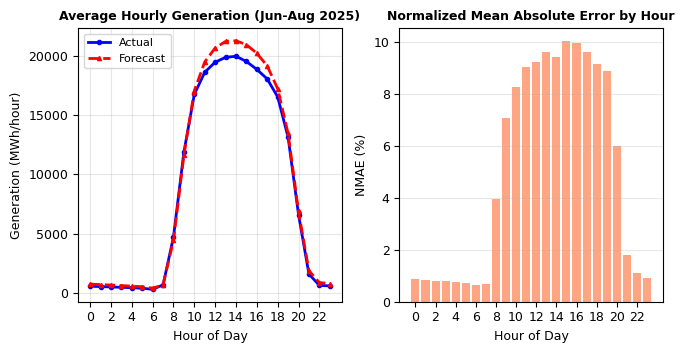

In [22]:
# Step 6: Analyze hourly performance by hour of day
# Group by hour to see performance at different times

hourly_metrics_by_hour = []

for hour in range(24):
    hour_data = hourly_comparison[hourly_comparison['hour'] == hour]
    
    if len(hour_data) == 0:
        continue
    
    # Calculate metrics for this hour
    mae_h = mean_absolute_error(hour_data['actual'], hour_data['hourly_forecast'])
    rmse_h = np.sqrt(mean_squared_error(hour_data['actual'], hour_data['hourly_forecast']))
    
    # Only calculate MAPE and R2 if there's sufficient generation (daylight hours)
    if hour_data['actual'].mean() >= 1.0:
        # MAPE excluding zeros
        non_zero = hour_data['actual'] > 0
        if non_zero.sum() > 0:
            mape_h = np.mean(np.abs((hour_data.loc[non_zero, 'actual'] - 
                                    hour_data.loc[non_zero, 'hourly_forecast']) / 
                                   hour_data.loc[non_zero, 'actual'])) * 100
        else:
            mape_h = np.nan
        
        # R² only for daylight hours
        if len(hour_data) > 1:
            r2_h = r2_score(hour_data['actual'], hour_data['hourly_forecast'])
        else:
            r2_h = np.nan
    else:
        mape_h = np.nan
        r2_h = np.nan
    
    hourly_metrics_by_hour.append({
        'hour': hour,
        'count': len(hour_data),
        'mean_actual': hour_data['actual'].mean(),
        'mean_forecast': hour_data['hourly_forecast'].mean(),
        'mae': mae_h,
        'rmse': rmse_h,
        'mape': mape_h,
        'r2': r2_h,
        'nmae': (mae_h / installed_capacity_hourly) * 100,
    })

hourly_metrics_df = pd.DataFrame(hourly_metrics_by_hour)

print("\nHourly Performance Metrics by Hour of Day:")
print("="*100)
print(hourly_metrics_df.to_string(index=False))
print("="*100)

# Visualize hourly metrics
fig, axes = plt.subplots(1, 2, figsize=(6.8, 3.6))

# Plot 1: Average generation by hour
ax1 = axes[0]
ax1.plot(hourly_metrics_df['hour'], hourly_metrics_df['mean_actual'], 
         marker='o', label='Actual', color='blue')#, linewidth=2, markersize=7)
ax1.plot(hourly_metrics_df['hour'], hourly_metrics_df['mean_forecast'], 
         marker='^', label='Forecast', color='red', linestyle='--')#, linewidth=2, markersize=7)
ax1.set_title('Average Hourly Generation (Jun-Aug 2025)', fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Generation (MWh/hour)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 2))

# Plot 2: NMAE by hour
ax2 = axes[1]
ax2.bar(hourly_metrics_df['hour'], hourly_metrics_df['nmae'], alpha=0.7, color='coral')
ax2.set_title('Normalized Mean Absolute Error by Hour', fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('NMAE (%)')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(0, 24, 2))

# Plot 3: RMSE by hour
#ax3 = axes[1, 0]
#ax3.bar(hourly_metrics_df['hour'], hourly_metrics_df['rmse'], alpha=0.7, color='steelblue')
#ax3.set_title('Root Mean Squared Error by Hour', fontweight='bold')
#ax3.set_xlabel('Hour of Day')
#ax3.set_ylabel('RMSE (MWh/hour)')
#ax3.grid(True, alpha=0.3, axis='y')
#ax3.set_xticks(range(0, 24, 2))

# Plot 4: MAPE by hour (only daylight hours)
#ax4 = axes[1, 1]
#daylight_data = hourly_metrics_df[~hourly_metrics_df['mape'].isna()]
#ax4.bar(daylight_data['hour'], daylight_data['mape'], alpha=0.7, color='lightgreen')
#ax4.set_title('MAPE by Hour (Daylight Hours Only)', fontweight='bold')
#ax4.set_xlabel('Hour of Day')
#ax4.set_ylabel('MAPE (%)')
#ax4.grid(True, alpha=0.3, axis='y')
#ax4.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('figures/prophet_6-8_daily_disagg.pdf')
plt.show()

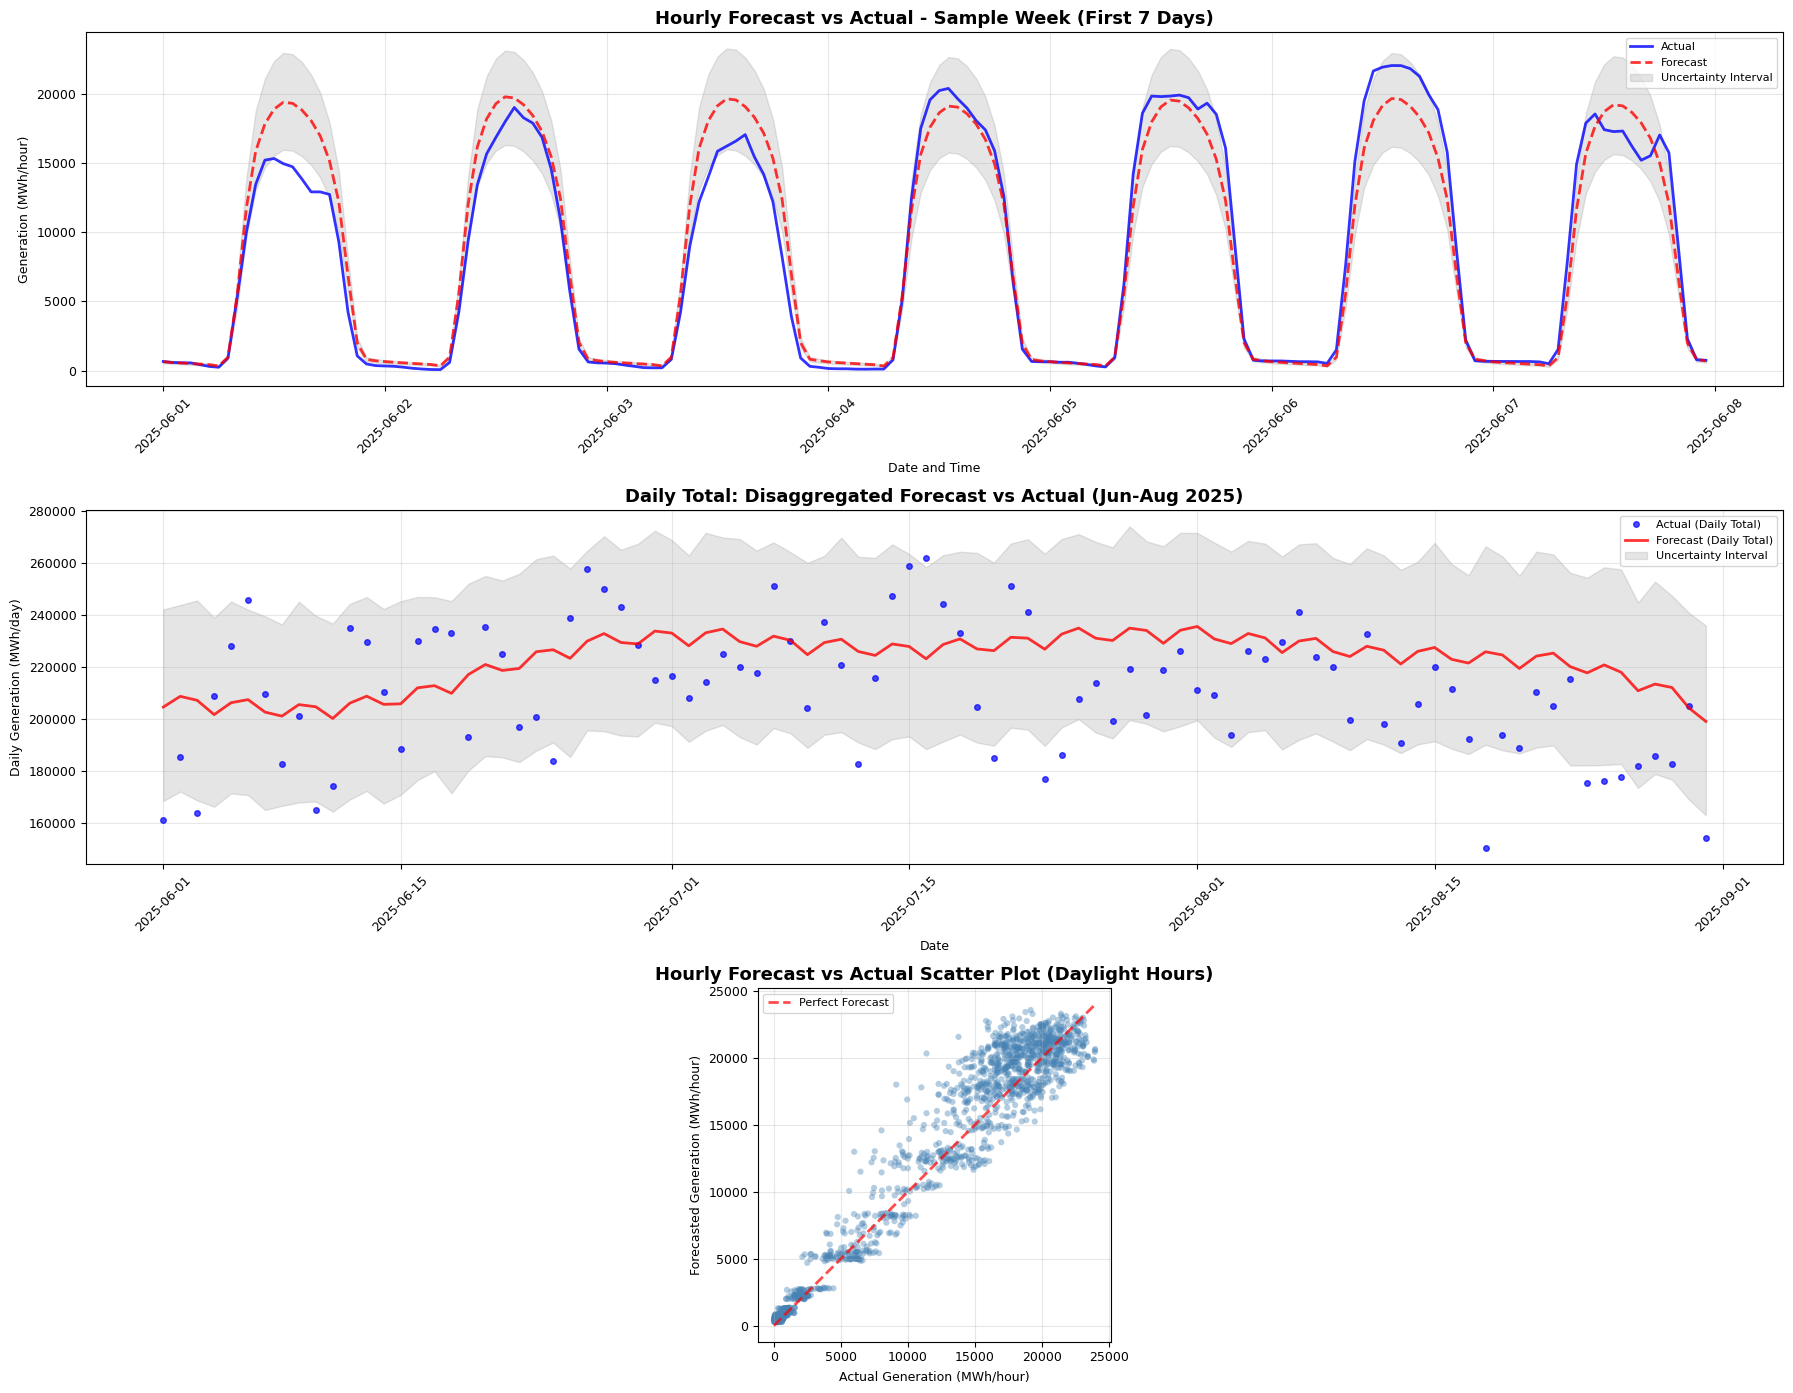


Visualization complete.
Daily totals comparison: 92 days
Hourly datapoints (daylight): 2208 hours


In [23]:
# Step 7: Visualize hourly forecast vs actual over time
# Plot sample days and overall comparison

# Select a few sample days for detailed visualization
sample_dates = hourly_comparison['datetime'].dt.date.unique()[:7]  # First week

fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# Plot 1: Sample week hourly comparison
sample_data = hourly_comparison[hourly_comparison['datetime'].dt.date.isin(sample_dates)]
ax1 = axes[0]
ax1.plot(sample_data['datetime'], sample_data['actual'], 
         'b-', linewidth=2, label='Actual', alpha=0.8)
ax1.plot(sample_data['datetime'], sample_data['hourly_forecast'], 
         'r--', linewidth=2, label='Forecast', alpha=0.8)
ax1.fill_between(sample_data['datetime'], 
                 sample_data['hourly_lower'], 
                 sample_data['hourly_upper'],
                 color='gray', alpha=0.2, label='Uncertainty Interval')
ax1.set_title('Hourly Forecast vs Actual - Sample Week (First 7 Days)', fontweight='bold', fontsize=13)
ax1.set_xlabel('Date and Time')
ax1.set_ylabel('Generation (MWh/hour)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Full period overview (daily aggregated view for clarity)
hourly_comparison['date'] = hourly_comparison['datetime'].dt.date
daily_agg = hourly_comparison.groupby('date').agg({
    'actual': 'sum',
    'hourly_forecast': 'sum',
    'hourly_lower': 'sum',
    'hourly_upper': 'sum'
}).reset_index()
daily_agg['date'] = pd.to_datetime(daily_agg['date'])

ax2 = axes[1]
ax2.plot(daily_agg['date'], daily_agg['actual'], 
         'b.', markersize=8, label='Actual (Daily Total)', alpha=0.7)
ax2.plot(daily_agg['date'], daily_agg['hourly_forecast'], 
         'r-', linewidth=2, label='Forecast (Daily Total)', alpha=0.8)
ax2.fill_between(daily_agg['date'], 
                 daily_agg['hourly_lower'], 
                 daily_agg['hourly_upper'],
                 color='gray', alpha=0.2, label='Uncertainty Interval')
ax2.set_title('Daily Total: Disaggregated Forecast vs Actual (Jun-Aug 2025)', fontweight='bold', fontsize=13)
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Generation (MWh/day)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Scatter plot - Forecast vs Actual (hourly)
ax3 = axes[2]
# Only plot daylight hours for clarity
daylight_mask = hourly_comparison['actual'] >= 1.0
scatter_data = hourly_comparison[daylight_mask]
ax3.scatter(scatter_data['actual'], scatter_data['hourly_forecast'], 
           alpha=0.4, s=20, color='steelblue', edgecolors='none')
# Perfect forecast line
max_val = max(scatter_data['actual'].max(), scatter_data['hourly_forecast'].max())
ax3.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Forecast', alpha=0.7)
ax3.set_title('Hourly Forecast vs Actual Scatter Plot (Daylight Hours)', fontweight='bold', fontsize=13)
ax3.set_xlabel('Actual Generation (MWh/hour)')
ax3.set_ylabel('Forecasted Generation (MWh/hour)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print(f"\nVisualization complete.")
print(f"Daily totals comparison: {len(daily_agg)} days")
print(f"Hourly datapoints (daylight): {daylight_mask.sum()} hours")

In [24]:
# Step 10: Summary comparison - Daily vs Hourly Disaggregated Metrics
# Calculate daily metrics from aggregated hourly data for comparison

print("\n" + "="*80)
print("COMPARISON: DAILY vs HOURLY DISAGGREGATED FORECAST METRICS")
print("="*80)

# Calculate daily totals from hourly disaggregated data
hourly_comparison_copy = hourly_comparison.copy()
hourly_comparison_copy['date_only'] = hourly_comparison_copy['datetime'].dt.date
daily_from_hourly = hourly_comparison_copy.groupby('date_only').agg({
    'actual': 'sum',
    'hourly_forecast': 'sum'
}).reset_index()
daily_from_hourly.columns = ['date', 'daily_actual', 'daily_forecast']

# Calculate daily metrics from the aggregated hourly data
mae_daily = mean_absolute_error(daily_from_hourly['daily_actual'], 
                                 daily_from_hourly['daily_forecast'])
rmse_daily = np.sqrt(mean_squared_error(daily_from_hourly['daily_actual'], 
                                         daily_from_hourly['daily_forecast']))

# MAPE for daily (excluding very low generation days)
threshold_daily = 100  # MWh/day
significant_mask_daily = daily_from_hourly['daily_actual'] >= threshold_daily
if significant_mask_daily.sum() > 0:
    mape_daily = np.mean(np.abs(
        (daily_from_hourly.loc[significant_mask_daily, 'daily_actual'] - 
         daily_from_hourly.loc[significant_mask_daily, 'daily_forecast']) / 
        daily_from_hourly.loc[significant_mask_daily, 'daily_actual']
    )) * 100
else:
    mape_daily = np.nan

print("\nDAILY METRICS (aggregated from hourly data):")
print(f"  Observations: {len(daily_from_hourly)} days")
print(f"  MAE:  {mae_daily:.2f} MWh/day")
print(f"  RMSE: {rmse_daily:.2f} MWh/day")
if not np.isnan(mape_daily):
    print(f"  MAPE: {mape_daily:.2f}%")

# Hourly metrics (just calculated)
print("\nHOURLY DISAGGREGATED FORECAST METRICS:")
print(f"  Observations: {len(hourly_comparison)} hours ({daylight_hours} daylight hours)")
print(f"  MAE:  {mae_hourly:.2f} MWh/hour")
print(f"  RMSE: {rmse_hourly:.2f} MWh/hour")
print(f"  R²:   {r2_hourly:.4f}")
if not np.isnan(mape_hourly):
    print(f"  MAPE (daylight hours): {mape_hourly:.2f}%")
print(f"  nMAE:  {nmae_hourly:.2f}% of installed capacity")
print(f"  nRMSE: {nrmse_hourly:.2f}% of installed capacity")

print("\nDATA RANGES:")
print(f"Daily:")
print(f"  Actual: {daily_from_hourly['daily_actual'].min():.2f} to {daily_from_hourly['daily_actual'].max():.2f} MWh/day")
print(f"  Forecast: {daily_from_hourly['daily_forecast'].min():.2f} to {daily_from_hourly['daily_forecast'].max():.2f} MWh/day")
print(f"Hourly:")
print(f"  Actual: {hourly_comparison['actual'].min():.2f} to {hourly_comparison['actual'].max():.2f} MWh/hour")
print(f"  Forecast: {hourly_comparison['hourly_forecast'].min():.2f} to {hourly_comparison['hourly_forecast'].max():.2f} MWh/hour")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("1. Daily forecast MAE represents the error when forecasting full day totals")
print("2. Hourly disaggregation preserves daily totals (MAE should be identical)")
print("3. Hourly metrics show the intra-day forecast performance")
print("4. Weight factors based on historical irradiation patterns successfully")
print("   distribute daily totals to hourly values")
print(f"5. The disaggregation maintains total energy: Daily MAE = {mae_daily:.2f} MWh/day")
print("="*80)


COMPARISON: DAILY vs HOURLY DISAGGREGATED FORECAST METRICS

DAILY METRICS (aggregated from hourly data):
  Observations: 92 days
  MAE:  21590.99 MWh/day
  RMSE: 25600.02 MWh/day
  MAPE: 10.93%

HOURLY DISAGGREGATED FORECAST METRICS:
  Observations: 2208 hours (2208 daylight hours)
  MAE:  1072.58 MWh/hour
  RMSE: 1700.02 MWh/hour
  R²:   0.9601
  MAPE (daylight hours): 44.38%
  nMAE:  5.00% of installed capacity
  nRMSE: 7.93% of installed capacity

DATA RANGES:
Daily:
  Actual: 150318.00 to 261864.00 MWh/day
  Forecast: 198934.11 to 235488.66 MWh/day
Hourly:
  Actual: 7.00 to 23999.00 MWh/hour
  Forecast: 254.19 to 23576.43 MWh/hour

KEY INSIGHTS:
1. Daily forecast MAE represents the error when forecasting full day totals
2. Hourly disaggregation preserves daily totals (MAE should be identical)
3. Hourly metrics show the intra-day forecast performance
4. Weight factors based on historical irradiation patterns successfully
   distribute daily totals to hourly values
5. The disaggrega

In [25]:
# Summary statistics for hourly comparison data (already created earlier)
print("=" * 70)
print("HOURLY COMPARISON SUMMARY (2025 June-August)")
print("=" * 70)
print(f"Total hourly observations: {len(hourly_comparison)}")
print(f"Date range: {hourly_comparison['datetime'].min()} to {hourly_comparison['datetime'].max()}")

# Check for nighttime hours (zero or very low generation)
zero_counts = (hourly_comparison['actual'] == 0).sum()
low_counts = ((hourly_comparison['actual'] > 0) & (hourly_comparison['actual'] < 1)).sum()
print(f"\nZero generation hours: {zero_counts}")
print(f"Very low generation hours (<1 MWh): {low_counts}")
print(f"Daylight hours (>= 1 MWh): {daylight_hours}")

# Hourly statistics
print(f"\nHourly Generation Statistics:")
print(f"  Actual:")
print(f"    Mean: {hourly_comparison['actual'].mean():.2f} MWh/hour")
print(f"    Min: {hourly_comparison['actual'].min():.2f} MWh/hour")
print(f"    Max: {hourly_comparison['actual'].max():.2f} MWh/hour")
print(f"    Std: {hourly_comparison['actual'].std():.2f} MWh/hour")
print(f"  Forecast:")
print(f"    Mean: {hourly_comparison['hourly_forecast'].mean():.2f} MWh/hour")
print(f"    Min: {hourly_comparison['hourly_forecast'].min():.2f} MWh/hour")
print(f"    Max: {hourly_comparison['hourly_forecast'].max():.2f} MWh/hour")
print(f"    Std: {hourly_comparison['hourly_forecast'].std():.2f} MWh/hour")

# Daily totals from hourly data
hourly_comparison['date'] = hourly_comparison['datetime'].dt.date
daily_totals = hourly_comparison.groupby('date').agg({
    'actual': 'sum',
    'hourly_forecast': 'sum'
}).reset_index()

print(f"\nDaily Totals (aggregated from hourly):")
print(f"  Actual daily total: {daily_totals['actual'].sum():.2f} MWh")
print(f"  Forecast daily total: {daily_totals['hourly_forecast'].sum():.2f} MWh")
print(f"  Difference: {(daily_totals['hourly_forecast'].sum() - daily_totals['actual'].sum()):.2f} MWh")
print(f"  Percentage difference: {((daily_totals['hourly_forecast'].sum() - daily_totals['actual'].sum())/daily_totals['actual'].sum()*100):.2f}%")
print("=" * 70)

HOURLY COMPARISON SUMMARY (2025 June-August)
Total hourly observations: 2208
Date range: 2025-06-01 00:00:00 to 2025-08-31 23:00:00

Zero generation hours: 0
Very low generation hours (<1 MWh): 0
Daylight hours (>= 1 MWh): 2208

Hourly Generation Statistics:
  Actual:
    Mean: 8784.29 MWh/hour
    Min: 7.00 MWh/hour
    Max: 23999.00 MWh/hour
    Std: 8509.10 MWh/hour
  Forecast:
    Mean: 9257.26 MWh/hour
    Min: 254.19 MWh/hour
    Max: 23576.43 MWh/hour
    Std: 8808.62 MWh/hour

Daily Totals (aggregated from hourly):
  Actual daily total: 19395714.67 MWh
  Forecast daily total: 20440040.46 MWh
  Difference: 1044325.80 MWh
  Percentage difference: 5.38%


In [26]:
# Recalculate metrics with proper handling for nighttime hours
print("\n" + "=" * 70)
print("REFINED HOURLY METRICS ANALYSIS")
print("=" * 70)

# Calculate error for daylight hours only (where generation is significant)
daylight_data = hourly_comparison[hourly_comparison['actual'] >= 1.0].copy()

if len(daylight_data) > 0:
    mae_daylight = mean_absolute_error(daylight_data['actual'], daylight_data['hourly_forecast'])
    rmse_daylight = np.sqrt(mean_squared_error(daylight_data['actual'], daylight_data['hourly_forecast']))
    r2_daylight = r2_score(daylight_data['actual'], daylight_data['hourly_forecast'])
    
    # MAPE for daylight hours
    mape_daylight = np.mean(np.abs(
        (daylight_data['actual'] - daylight_data['hourly_forecast']) / daylight_data['actual']
    )) * 100
    
    print(f"\nDaylight Hours Only (generation >= 1 MWh/hour):")
    print(f"  Observations: {len(daylight_data)} hours")
    print(f"  MAE: {mae_daylight:.2f} MWh/hour")
    print(f"  RMSE: {rmse_daylight:.2f} MWh/hour")
    print(f"  MAPE: {mape_daylight:.2f}%")
    print(f"  R²: {r2_daylight:.4f}")

# All hours metrics (already calculated earlier)
print(f"\nAll Hours (including nighttime):")
print(f"  Observations: {len(hourly_comparison)} hours")
print(f"  MAE: {mae_hourly:.2f} MWh/hour")
print(f"  RMSE: {rmse_hourly:.2f} MWh/hour")
print(f"  R²: {r2_hourly:.4f}")
print(f"  nMAE: {nmae_hourly:.2f}% of installed capacity")

print(f"  nRMSE: {nrmse_hourly:.2f}% of installed capacity")
print("=" * 70)


REFINED HOURLY METRICS ANALYSIS

Daylight Hours Only (generation >= 1 MWh/hour):
  Observations: 2208 hours
  MAE: 1072.58 MWh/hour
  RMSE: 1700.02 MWh/hour
  MAPE: 44.38%
  R²: 0.9601

All Hours (including nighttime):
  Observations: 2208 hours
  MAE: 1072.58 MWh/hour
  RMSE: 1700.02 MWh/hour
  R²: 0.9601
  nMAE: 5.00% of installed capacity
  nRMSE: 7.93% of installed capacity


In [27]:
# Calculate persistence model skill score for hourly data
# Persistence model: use previous hour as forecast
print("\n" + "=" * 70)
print("PERSISTENCE MODEL COMPARISON (Hourly)")
print("=" * 70)

hourly_sorted = hourly_comparison.sort_values('datetime').reset_index(drop=True)
persistence_hourly = hourly_sorted['actual'].shift(1)

# Calculate skill score for all hours
valid_mask_h = ~persistence_hourly.isna()
if valid_mask_h.sum() > 1:
    persistence_mse_h = mean_squared_error(
        hourly_sorted.loc[valid_mask_h, 'actual'],
        persistence_hourly[valid_mask_h]
    )
    model_mse_h = mean_squared_error(
        hourly_sorted.loc[valid_mask_h, 'actual'],
        hourly_sorted.loc[valid_mask_h, 'hourly_forecast']
    )
    skill_score_h = (1 - model_mse_h/persistence_mse_h) * 100
    
    print(f"Persistence Model (previous hour as forecast):")
    print(f"  Persistence MSE: {persistence_mse_h:.2f}")
    print(f"  Model MSE: {model_mse_h:.2f}")
    print(f"  Forecast Skill Score: {skill_score_h:.2f}% improvement over persistence")
else:
    skill_score_h = np.nan
    print(f"Forecast Skill Score: N/A")

# Show peak hours performance (typically 10 AM to 4 PM)
print(f"\nPerformance by time period:")
for period_name, hour_range in [('Morning (6-9)', range(6, 10)), 
                                 ('Peak (10-14)', range(10, 15)),
                                 ('Afternoon (15-18)', range(15, 19)),
                                 ('Evening (19-21)', range(19, 22))]:
    period_data = hourly_comparison[hourly_comparison['hour'].isin(hour_range)]
    if len(period_data) > 0 and period_data['actual'].mean() >= 1.0:
        period_mae = mean_absolute_error(period_data['actual'], period_data['hourly_forecast'])
        period_mape = np.mean(np.abs(
            (period_data['actual'] - period_data['hourly_forecast']) / period_data['actual']
        )) * 100
        print(f"  {period_name:20s}: MAE = {period_mae:6.2f} MWh/hour, MAPE = {period_mape:6.2f}%")
print("=" * 70)


PERSISTENCE MODEL COMPARISON (Hourly)
Persistence Model (previous hour as forecast):
  Persistence MSE: 8119315.64
  Model MSE: 2891390.51
  Forecast Skill Score: 64.39% improvement over persistence

Performance by time period:
  Morning (6-9)       : MAE = 661.43 MWh/hour, MAPE =  58.07%
  Peak (10-14)        : MAE = 1952.19 MWh/hour, MAPE =  11.11%
  Afternoon (15-18)   : MAE = 2074.69 MWh/hour, MAPE =  12.47%
  Evening (19-21)     : MAE = 1190.10 MWh/hour, MAPE =  26.81%


In [28]:
# Hourly metrics summary visualization (reference to earlier detailed analysis)
print("\n" + "=" * 70)
print("HOURLY METRICS SUMMARY")
print("=" * 70)
print(f"\nDetailed hourly-by-hour analysis was shown earlier (cell 24).")
print(f"Key findings:")

# Find best and worst performing hours
best_hour = hourly_metrics_df.loc[hourly_metrics_df['mae'].idxmin()]
worst_hour_daylight = hourly_metrics_df[hourly_metrics_df['mean_actual'] >= 10].loc[
    hourly_metrics_df[hourly_metrics_df['mean_actual'] >= 10]['mae'].idxmax()
]

print(f"\nBest performing hour:")
print(f"  Hour {int(best_hour['hour'])}: MAE = {best_hour['mae']:.2f} MWh/hour")
print(f"\nWorst performing daylight hour (>10 MWh avg generation):")
print(f"  Hour {int(worst_hour_daylight['hour'])}: MAE = {worst_hour_daylight['mae']:.2f} MWh/hour")

# Summary of peak hours
peak_hours_data = hourly_metrics_df[(hourly_metrics_df['hour'] >= 10) & (hourly_metrics_df['hour'] <= 14)]
print(f"\nPeak hours (10:00-14:00) performance:")
print(f"  Average MAE: {peak_hours_data['mae'].mean():.2f} MWh/hour")
print(f"  Average RMSE: {peak_hours_data['rmse'].mean():.2f} MWh/hour")
if not peak_hours_data['mape'].isna().all():
    print(f"  Average MAPE: {peak_hours_data['mape'].mean():.2f}%")

print("=" * 70)


HOURLY METRICS SUMMARY

Detailed hourly-by-hour analysis was shown earlier (cell 24).
Key findings:

Best performing hour:
  Hour 6: MAE = 135.44 MWh/hour

Worst performing daylight hour (>10 MWh avg generation):
  Hour 15: MAE = 2147.30 MWh/hour

Peak hours (10:00-14:00) performance:
  Average MAE: 1952.19 MWh/hour
  Average RMSE: 2410.61 MWh/hour
  Average MAPE: 11.11%



HOURLY ERROR DISTRIBUTION ANALYSIS

Error Statistics (daylight hours only):
  Mean Error: 472.97 MWh/hour (bias)
  Std Dev of Error: 1633.27 MWh/hour
  Mean Absolute Error: 1072.58 MWh/hour
  Median Absolute Error: 433.37 MWh/hour

Percentage Error Statistics:
  Mean % Error: 38.40%
  Median % Error: 10.95%
  Std Dev % Error: 163.92%


C:\Users\Archer\AppData\Local\Temp\ipykernel_19032\4226884104.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(hourly_groups, labels=hour_labels)


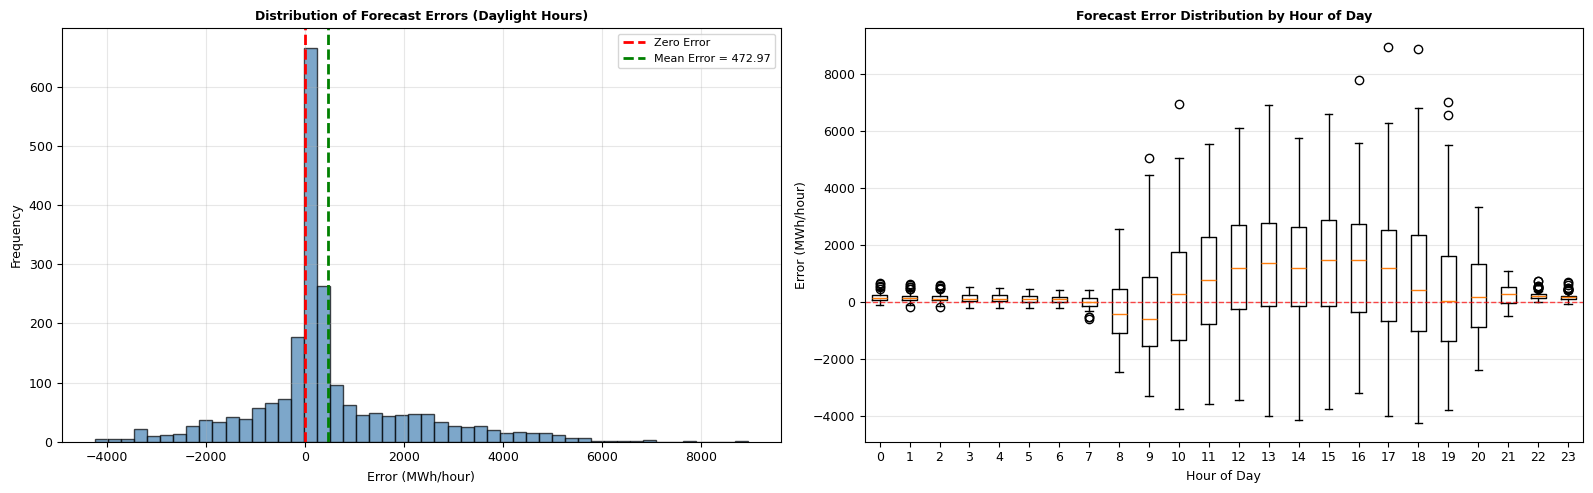

In [29]:
# Additional hourly visualization - error distribution
print("\n" + "=" * 70)
print("HOURLY ERROR DISTRIBUTION ANALYSIS")
print("=" * 70)

# Calculate errors for daylight hours
daylight_data = hourly_comparison[hourly_comparison['actual'] >= 1.0].copy()
daylight_data['error'] = daylight_data['hourly_forecast'] - daylight_data['actual']
daylight_data['abs_error'] = np.abs(daylight_data['error'])
daylight_data['pct_error'] = (daylight_data['error'] / daylight_data['actual']) * 100

# Error statistics
print(f"\nError Statistics (daylight hours only):")
print(f"  Mean Error: {daylight_data['error'].mean():.2f} MWh/hour (bias)")
print(f"  Std Dev of Error: {daylight_data['error'].std():.2f} MWh/hour")
print(f"  Mean Absolute Error: {daylight_data['abs_error'].mean():.2f} MWh/hour")
print(f"  Median Absolute Error: {daylight_data['abs_error'].median():.2f} MWh/hour")
print(f"\nPercentage Error Statistics:")
print(f"  Mean % Error: {daylight_data['pct_error'].mean():.2f}%")
print(f"  Median % Error: {daylight_data['pct_error'].median():.2f}%")
print(f"  Std Dev % Error: {daylight_data['pct_error'].std():.2f}%")

# Plot error distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of errors
ax1 = axes[0]
ax1.hist(daylight_data['error'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax1.axvline(x=daylight_data['error'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean Error = {daylight_data["error"].mean():.2f}')
ax1.set_title('Distribution of Forecast Errors (Daylight Hours)', fontweight='bold')
ax1.set_xlabel('Error (MWh/hour)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot by hour of day
ax2 = axes[1]
hourly_groups = [daylight_data[daylight_data['hour'] == h]['error'].values 
                 for h in range(24) if len(daylight_data[daylight_data['hour'] == h]) > 0]
hour_labels = [h for h in range(24) if len(daylight_data[daylight_data['hour'] == h]) > 0]
ax2.boxplot(hourly_groups, labels=hour_labels)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax2.set_title('Forecast Error Distribution by Hour of Day', fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Error (MWh/hour)')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("=" * 70)



MONTHLY HOURLY FORECAST PERFORMANCE (June-August 2025)
Month         MAE        RMSE      MAPE       R²    nRMSE
  Jun 1055.232949 1582.819413 63.652193 0.965057 7.298000
  Jul 1037.140630 1633.575869 21.028172 0.963348 7.640655
  Aug 1124.796775 1866.532717 49.080011 0.951796 8.800498


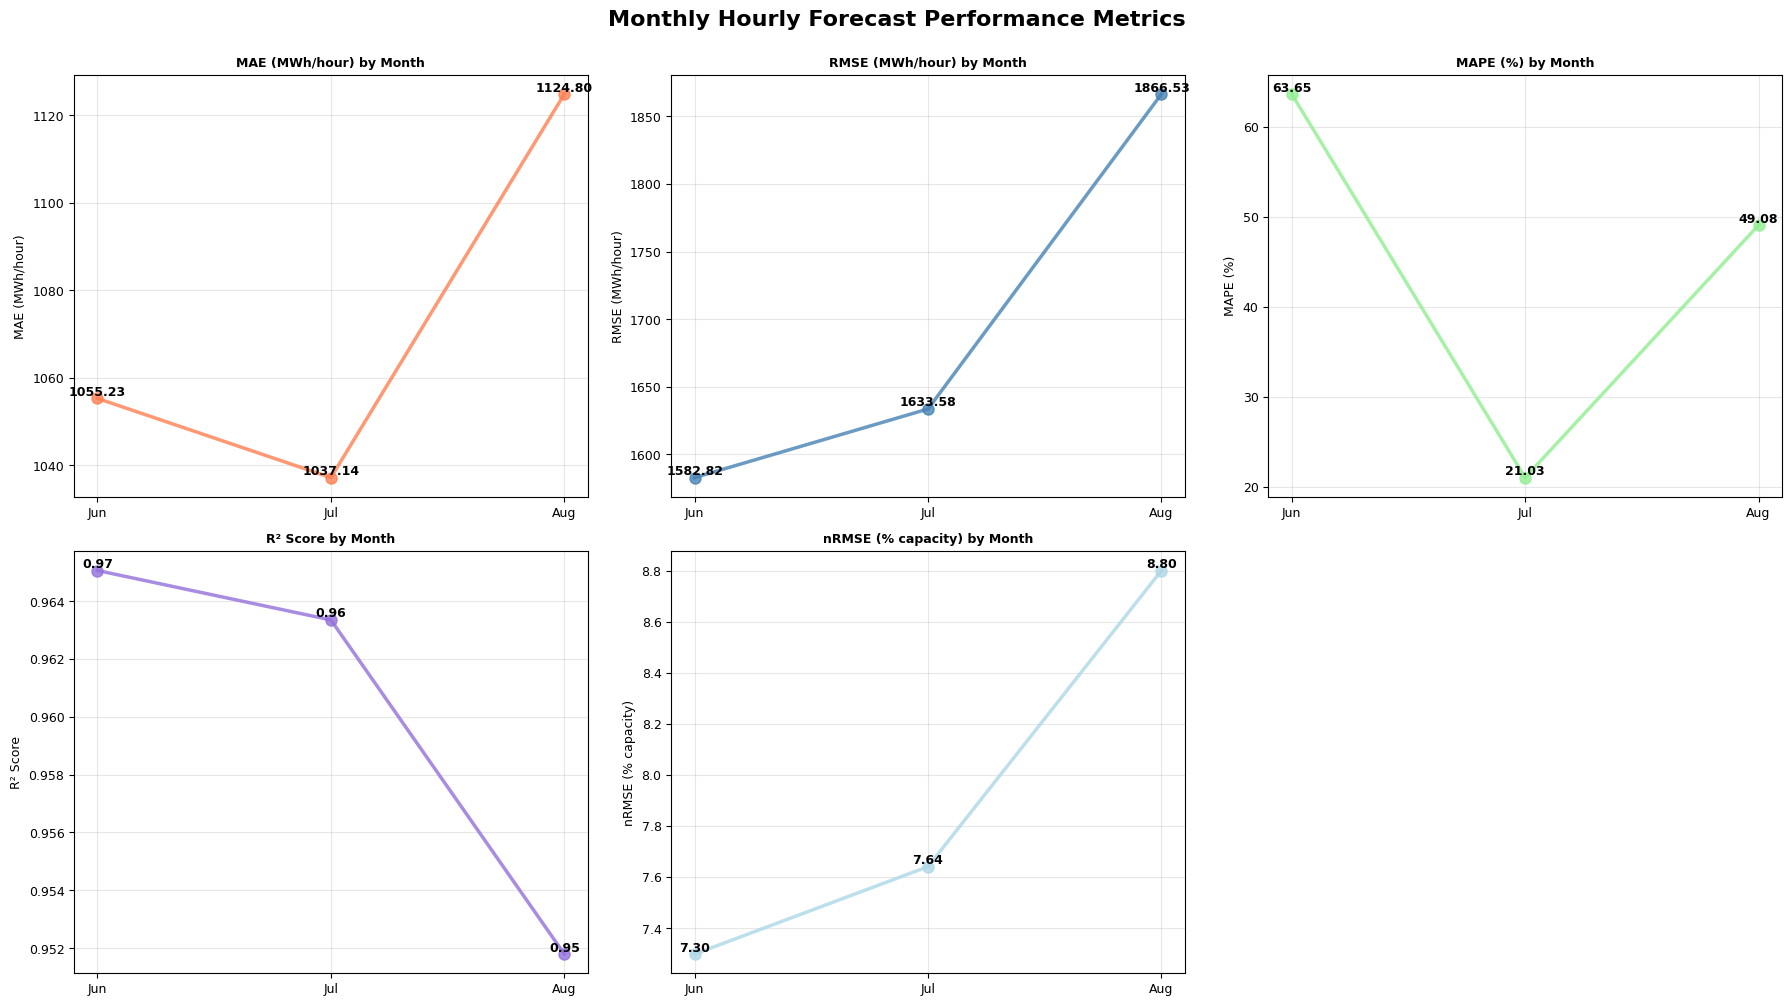

In [30]:
# Step 8: Monthly analysis of hourly forecasts
# Compare performance across different months

monthly_hourly_metrics = []

for month in [6, 7, 8]:
    month_data = hourly_comparison[hourly_comparison['month'] == month]
    
    if len(month_data) == 0:
        continue
    
    # Overall metrics
    mae_m = mean_absolute_error(month_data['actual'], month_data['hourly_forecast'])
    rmse_m = np.sqrt(mean_squared_error(month_data['actual'], month_data['hourly_forecast']))
    r2_m = r2_score(month_data['actual'], month_data['hourly_forecast'])
    
    # MAPE for daylight hours only
    daylight_mask = month_data['actual'] >= 1.0
    if daylight_mask.sum() > 0:
        mape_m = np.mean(np.abs((month_data.loc[daylight_mask, 'actual'] - 
                                month_data.loc[daylight_mask, 'hourly_forecast']) / 
                               month_data.loc[daylight_mask, 'actual'])) * 100
    else:
        mape_m = np.nan
    
    # Normalized metrics
    installed_cap_m = month_data['actual'].quantile(0.95)
    nmae_m = (mae_m / installed_cap_m) * 100
    nrmse_m = (rmse_m / installed_cap_m) * 100
    
    monthly_hourly_metrics.append({
        'Month': {6: 'Jun', 7: 'Jul', 8: 'Aug'}[month],
        'MAE': mae_m,
        'RMSE': rmse_m,
        'MAPE': mape_m,
        'R²': r2_m,
        'nRMSE': nrmse_m
    })

monthly_metrics_hourly_df = pd.DataFrame(monthly_hourly_metrics)

print("\n" + "="*120)
print("MONTHLY HOURLY FORECAST PERFORMANCE (June-August 2025)")
print("="*120)
print(monthly_metrics_hourly_df.to_string(index=False))
print("="*120)

# Visualize monthly metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_to_plot = [
    ('MAE', 'MAE (MWh/hour)', 'coral'),
    ('RMSE', 'RMSE (MWh/hour)', 'steelblue'),
    ('MAPE', 'MAPE (%)', 'lightgreen'),
    ('R²', 'R² Score', 'mediumpurple'),
    ('nRMSE', 'nRMSE (% capacity)', 'lightblue')
]

for idx, (metric, ylabel, color) in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    ax.plot(monthly_metrics_hourly_df['Month'], monthly_metrics_hourly_df[metric], 
            marker='o', color=color, linewidth=2.5, markersize=8, alpha=0.8)
    ax.set_title(f'{ylabel} by Month', fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on data points
    for i, (month, v) in enumerate(zip(monthly_metrics_hourly_df['Month'], monthly_metrics_hourly_df[metric])):
        if not np.isnan(v):
            ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Hide unused subplot
axes[1, 2].axis('off')

plt.suptitle('Monthly Hourly Forecast Performance Metrics', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [31]:
# Step 9: Export hourly forecast and comparison data
# Save the disaggregated hourly forecast and comparison to CSV

# Export 1: Hourly forecast (all hours)
export_hourly_forecast = hourly_forecast_df.copy()
export_hourly_forecast['datetime_str'] = export_hourly_forecast['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
export_hourly_forecast_final = export_hourly_forecast[[
    'datetime_str', 'hour', 'month', 'weight', 
    'hourly_forecast', 'hourly_lower', 'hourly_upper'
]].rename(columns={
    'datetime_str': 'DateTime',
    'hour': 'Hour',
    'month': 'Month',
    'weight': 'Weight_Factor',
    'hourly_forecast': 'Forecast_Generation_MWh',
    'hourly_lower': 'Forecast_Lower_Bound_MWh',
    'hourly_upper': 'Forecast_Upper_Bound_MWh'
})

forecast_output_file = 'pv_forecast_2025_6-8_disaggregated.csv'
export_hourly_forecast_final.to_csv(forecast_output_file, index=False)
print(f"Hourly disaggregated forecast exported to: {forecast_output_file}")
print(f"Total hourly records: {len(export_hourly_forecast_final)}")

# Export 2: Hourly comparison (forecast vs actual)
export_hourly_comparison = hourly_comparison.copy()
export_hourly_comparison['datetime_str'] = export_hourly_comparison['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
export_hourly_comparison['error'] = export_hourly_comparison['hourly_forecast'] - export_hourly_comparison['actual']
export_hourly_comparison['abs_error'] = np.abs(export_hourly_comparison['error'])
export_hourly_comparison['pct_error'] = np.where(
    export_hourly_comparison['actual'] > 0,
    (export_hourly_comparison['error'] / export_hourly_comparison['actual']) * 100,
    np.nan
)

export_hourly_comparison_final = export_hourly_comparison[[
    'datetime_str', 'hour', 'month',
    'actual', 'hourly_forecast', 'hourly_lower', 'hourly_upper',
    'error', 'abs_error', 'pct_error'
]].rename(columns={
    'datetime_str': 'DateTime',
    'hour': 'Hour',
    'month': 'Month',
    'actual': 'Actual_Generation_MWh',
    'hourly_forecast': 'Forecast_Generation_MWh',
    'hourly_lower': 'Forecast_Lower_Bound_MWh',
    'hourly_upper': 'Forecast_Upper_Bound_MWh',
    'error': 'Error_MWh',
    'abs_error': 'Absolute_Error_MWh',
    'pct_error': 'Percentage_Error'
})

comparison_output_file = 'pv_forecast_2025_jun_aug_hourly_comparison.csv'
export_hourly_comparison_final.to_csv(comparison_output_file, index=False)
print(f"\nHourly comparison (forecast vs actual) exported to: {comparison_output_file}")
print(f"Total hourly records: {len(export_hourly_comparison_final)}")

# Export 3: Monthly summary metrics
monthly_summary = monthly_metrics_hourly_df.copy()
monthly_output_file = 'pv_metrics_6-8_disagg.csv'
monthly_summary.to_csv(monthly_output_file, index=False)
print(f"\nMonthly summary metrics exported to: {monthly_output_file}")

print("\n" + "="*70)
print("EXPORT SUMMARY")
print("="*70)
print(f"1. Hourly Forecast: {forecast_output_file}")
print(f"   - {len(export_hourly_forecast_final)} hourly records")
print(f"   - Columns: DateTime, Hour, Month, Weight_Factor, Forecast values")
print(f"\n2. Hourly Comparison: {comparison_output_file}")
print(f"   - {len(export_hourly_comparison_final)} hourly records")
print(f"   - Columns: DateTime, Hour, Month, Actual, Forecast, Errors")
print(f"\n3. Monthly Metrics: {monthly_output_file}")
print(f"   - {len(monthly_summary)} months")
print(f"   - Columns: Month, Hours, MAE, RMSE, MAPE, R², nMAE, nRMSE")
print("="*70)

Hourly disaggregated forecast exported to: pv_forecast_2025_6-8_disaggregated.csv
Total hourly records: 2208

Hourly comparison (forecast vs actual) exported to: pv_forecast_2025_jun_aug_hourly_comparison.csv
Total hourly records: 2208

Monthly summary metrics exported to: pv_metrics_6-8_disagg.csv

EXPORT SUMMARY
1. Hourly Forecast: pv_forecast_2025_6-8_disaggregated.csv
   - 2208 hourly records
   - Columns: DateTime, Hour, Month, Weight_Factor, Forecast values

2. Hourly Comparison: pv_forecast_2025_jun_aug_hourly_comparison.csv
   - 2208 hourly records
   - Columns: DateTime, Hour, Month, Actual, Forecast, Errors

3. Monthly Metrics: pv_metrics_6-8_disagg.csv
   - 3 months
   - Columns: Month, Hours, MAE, RMSE, MAPE, R², nMAE, nRMSE


In [32]:
# Hourly data export was already completed in cell 27
# Display confirmation and file information
print("\n" + "=" * 70)
print("HOURLY DATA EXPORT CONFIRMATION")
print("=" * 70)
print(f"\nHourly data files were exported earlier:")
print(f"\n1. Hourly Forecast: {forecast_output_file}")
print(f"   Records: {len(export_hourly_forecast_final)}")
print(f"   Columns: DateTime, Hour, Month, Weight_Factor, Forecast values")

print(f"\n2. Hourly Comparison: {comparison_output_file}")
print(f"   Records: {len(export_hourly_comparison_final)}")
print(f"   Columns: DateTime, Hour, Month, Actual, Forecast, Errors")

print(f"\n3. Monthly Metrics: {monthly_output_file}")
print(f"   Records: {len(monthly_summary)}")
print(f"   Columns: Month, MAE, RMSE, MAPE, R², nRMSE")

print(f"\nSample of hourly comparison data (first 10 daylight hours):")
daylight_sample = export_hourly_comparison_final[
    export_hourly_comparison_final['Actual_Generation_MWh'] >= 1.0
].head(10)
print(daylight_sample[['DateTime', 'Hour', 'Actual_Generation_MWh', 'Forecast_Generation_MWh', 'Absolute_Error_MWh']].to_string(index=False))
print("=" * 70)


HOURLY DATA EXPORT CONFIRMATION

Hourly data files were exported earlier:

1. Hourly Forecast: pv_forecast_2025_6-8_disaggregated.csv
   Records: 2208
   Columns: DateTime, Hour, Month, Weight_Factor, Forecast values

2. Hourly Comparison: pv_forecast_2025_jun_aug_hourly_comparison.csv
   Records: 2208
   Columns: DateTime, Hour, Month, Actual, Forecast, Errors

3. Monthly Metrics: pv_metrics_6-8_disagg.csv
   Records: 3
   Columns: Month, MAE, RMSE, MAPE, R², nRMSE

Sample of hourly comparison data (first 10 daylight hours):
           DateTime  Hour  Actual_Generation_MWh  Forecast_Generation_MWh  Absolute_Error_MWh
2025-06-01 00:00:00     0                  654.0               634.412030           19.587970
2025-06-01 01:00:00     1                  588.0               584.952714            3.047286
2025-06-01 02:00:00     2                  563.0               545.077694           17.922306
2025-06-01 03:00:00     3                  554.0               501.163911           52.8360

In [33]:
# Export hourly metrics to CSV (already done, but display the data)
print(f"Hourly monthly metrics exported to: {monthly_output_file}")
monthly_metrics_hourly_df

Hourly monthly metrics exported to: pv_metrics_6-8_disagg.csv


,Month,MAE,RMSE,MAPE,R²,nRMSE
0,Jun,1055.232949,1582.819413,63.652193,0.965057,7.298000
1,Jul,1037.140630,1633.575869,21.028172,0.963348,7.640655
2,Aug,1124.796775,1866.532717,49.080011,0.951796,8.800498


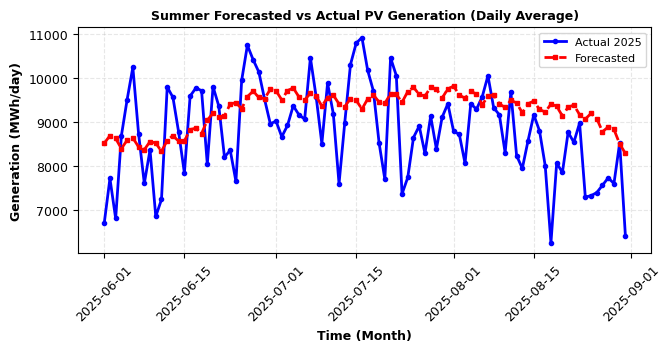


FORECAST vs ACTUAL COMPARISON SUMMARY (June - August 2025)
Total Days: 92

Actual Generation:
  Total: 808154.78 MWh
  Mean: 8784.29 MWh/day

Forecasted Generation:
  Total: 851668.35 MWh
  Mean: 9257.26 MWh/day

Forecast Error:
  Total Difference: 43513.57 MWh
  Percentage: 5.38%
  MAE: 899.62 MWh/day
  RMSE: 1066.67 MWh/day


In [34]:
# Comparison plot of forecasted vs actual data for June-August 2025
import matplotlib.pyplot as plt

# Prepare data: aggregate hourly to daily for cleaner visualization
hourly_comparison_plot = hourly_comparison.copy()
hourly_comparison_plot['date'] = hourly_comparison_plot['datetime'].dt.date

# Aggregate to daily totals
daily_comparison = hourly_comparison_plot.groupby('date').agg({
    'actual': 'mean',
    'hourly_forecast': 'mean'
}).reset_index()

# Convert date back to datetime for proper plotting
daily_comparison['date'] = pd.to_datetime(daily_comparison['date'])

# Create the comparison plot
fig, ax = plt.subplots(figsize=(6.8, 3.6))

# Plot actual and forecast lines
ax.plot(daily_comparison['date'], daily_comparison['actual'], 
        'b-', label='Actual 2025', marker='o')#, linewidth=2, markersize=3)
ax.plot(daily_comparison['date'], daily_comparison['hourly_forecast'], 
        'r--', label='Forecasted', marker='s')#, linewidth=2, markersize=3)

# Formatting
ax.set_xlabel('Time (Month)', fontweight='bold')#, fontsize=12)
ax.set_ylabel('Generation (MWh/day)', fontweight='bold')#, fontsize=12)
ax.set_title('Summer Forecasted vs Actual PV Generation (Daily Average)', fontweight='bold', 
                )#fontsize=14)
ax.legend(loc='best')#,frameon=True, shadow=True)#, fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis to show months
import matplotlib.dates as mdates
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
#ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/prophet_6-8_comp_disagg.pdf')
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("FORECAST vs ACTUAL COMPARISON SUMMARY (June - August 2025)")
print("="*70)
print(f"Total Days: {len(daily_comparison)}")
print(f"\nActual Generation:")
print(f"  Total: {daily_comparison['actual'].sum():.2f} MWh")
print(f"  Mean: {daily_comparison['actual'].mean():.2f} MWh/day")
print(f"\nForecasted Generation:")
print(f"  Total: {daily_comparison['hourly_forecast'].sum():.2f} MWh")
print(f"  Mean: {daily_comparison['hourly_forecast'].mean():.2f} MWh/day")
print(f"\nForecast Error:")
print(f"  Total Difference: {(daily_comparison['hourly_forecast'].sum() - daily_comparison['actual'].sum()):.2f} MWh")
print(f"  Percentage: {((daily_comparison['hourly_forecast'].sum() - daily_comparison['actual'].sum())/daily_comparison['actual'].sum()*100):.2f}%")
print(f"  MAE: {mean_absolute_error(daily_comparison['actual'], daily_comparison['hourly_forecast']):.2f} MWh/day")
print(f"  RMSE: {np.sqrt(mean_squared_error(daily_comparison['actual'], daily_comparison['hourly_forecast'])):.2f} MWh/day")
print("="*70)

In [35]:
hourly_comparison#_plot

,datetime,hour,month,hourly_forecast,hourly_lower,hourly_upper,actual,date
0,2025-06-01 00:00:00,0,6,634.412030,522.122654,751.089865,654.0,2025-06-01
1,2025-06-01 01:00:00,1,6,584.952714,481.417517,692.534243,588.0,2025-06-01
2,2025-06-01 02:00:00,2,6,545.077694,448.600278,645.325613,563.0,2025-06-01
3,2025-06-01 03:00:00,3,6,501.163911,412.459127,593.335430,554.0,2025-06-01
4,2025-06-01 04:00:00,4,6,468.807205,385.829478,555.027843,424.0,2025-06-01
...,...,...,...,...,...,...,...,...
2203,2025-08-31 19:00:00,19,8,11451.095519,9371.509320,13576.665924,8038.0,2025-08-31
2204,2025-08-31 20:00:00,20,8,4691.549126,3839.536251,5562.401872,2485.0,2025-08-31
2205,2025-08-31 21:00:00,21,8,1151.433979,942.326806,1365.164969,600.0,2025-08-31
2206,2025-08-31 22:00:00,22,8,769.878648,630.064164,912.784736,554.0,2025-08-31
